In [49]:
# Paso 1: Importación de bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold
from sklearn.metrics import (confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import kendalltau, pointbiserialr

# Integración de Weka (segura)
try:
    import weka.core.jvm as jvm
    from weka.core.converters import Loader
    from weka.classifiers import Classifier, Evaluation
    from weka.core.classes import Random
    weka_available = True
except:
    weka_available = False

# Integración de R (segura)
"""
try:
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    r_available = True
except:
    r_available = False
"""



'\ntry:\n    import rpy2.robjects as ro\n    from rpy2.robjects import pandas2ri\n    pandas2ri.activate()\n    r_available = True\nexcept:\n    r_available = False\n'

In [50]:
# Paso 1: Cargar el dataset
file_path = "adult-10.csv"
df = pd.read_csv(file_path)

FileNotFoundError: [Errno 2] No such file or directory: 'adult-10.csv'

In [ ]:
# Los datos ya están preprocesados y las variables X, y, X_train, X_valid, y_train, y_valid ya están definidas en celdas anteriores.
# Puedes continuar usando estas variables para tus experimentos.
print("Variables X, y, X_train, X_valid, y_train, y_valid ya están listas para usar.")

NameError: name 'df_admission' is not defined

In [45]:

le_repeated = LabelEncoder()
y_encoded = le_repeated.fit_transform(y)

def repeated_cv_metrics(model, X, y, n_repeats=20, n_splits=4, seed_base=42):
    metrics = {
        'accuracy': [], 'precision': [], 'recall': [], 'specificity': [],
        'f1': [], 'auc': [], 'mcc': [], 'kappa': []
    }
    
    for i in range(n_repeats):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_base + i)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

            # Matriz de confusión
            cm = confusion_matrix(y_test, y_pred)
            if cm.shape == (2, 2):  # caso binario
                tn, fp, fn, tp = cm.ravel()
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            else:  # multiclase
                specificities = []
                for j in range(cm.shape[0]):
                    tn = cm.sum() - (cm[j, :].sum() + cm[:, j].sum() - cm[j, j])
                    fp = cm[:, j].sum() - cm[j, j]
                    specificity_i = tn / (tn + fp) if (tn + fp) > 0 else 0
                    specificities.append(specificity_i)
                specificity = np.mean(specificities)

            # Métricas
            metrics['accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            metrics['recall'].append(recall_score(y_test, y_pred, average='macro'))
            metrics['specificity'].append(specificity)
            metrics['f1'].append(f1_score(y_test, y_pred, average='macro'))
            
            # AUC
            if y_proba is not None and not np.isnan(y_proba).any():
                try:
                    auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr')
                except ValueError:
                    auc_score = np.nan
            else:
                auc_score = np.nan
            metrics['auc'].append(auc_score)

            # Métricas adicionales
            metrics['mcc'].append(matthews_corrcoef(y_test, y_pred))
            metrics['kappa'].append(cohen_kappa_score(y_test, y_pred))

    return pd.DataFrame(metrics)

In [47]:
# Paso 5: Modelos
models = {
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'GBM': GradientBoostingClassifier(),
    'ERT': ExtraTreesClassifier(),# Nuevo
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),#nuevo
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()    
}

# Usar las variables preprocesadas X y y de CELL INDEX: 5
if 'X' in locals() and 'y' in locals() and not X.empty and not y.empty:
    X_clean = X
    y_clean = y
else:
    # Intentar cargar los datos preprocesados de CELL INDEX: 5
    try:
        try:
            if 'df_encoded' in locals() and not df_encoded.empty and 'income' in df_encoded.columns:
                X_clean = df_encoded.drop(columns=["income"])
                y_clean = df_encoded["income"]
            elif 'df' in locals() and not df.empty and 'income' in df.columns:
                # Recreate df_encoded from df if it exists
                categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
                if not categorical_cols:
                    raise ValueError("No se encontraron columnas categóricas en el DataFrame 'df'.")
                # Ensure 'income' is included in the categorical columns for encoding
                if 'income' not in categorical_cols:
                    categorical_cols.append('income')
                df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
                if 'income' in df_encoded.columns:
                    X_clean = df_encoded.drop(columns=["income"])
                    y_clean = df_encoded["income"]
                else:
                    raise ValueError("La columna 'income' no se encuentra en los datos procesados.")
            else:
                raise ValueError("df_encoded no está definido o está vacío. Asegúrate de que los datos estén preprocesados correctamente en las celdas anteriores.")
        except Exception as e:
            raise ValueError(f"Error al procesar los datos: {e}")
    except NameError:
        raise ValueError("X o y no están correctamente definidos. Asegúrate de que los datos estén preprocesados correctamente en las celdas anteriores.")

cv_results = {}
for model_label, model in models.items():
    print(f"Evaluando {model_label} con repeated CV...")
    df_cv = repeated_cv_metrics(model, X_clean, y_clean, n_repeats=20, n_splits=4)
    cv_results[model_label] = df_cv.mean()

# Compilar resultados en un DataFrame
df_cv_results = pd.DataFrame(cv_results).T
print("\nResultados de Repeated CV (promedios):")
print(df_cv_results)

# Guardar a CSV
df_cv_results.to_csv("resultados_repeated_cv_admision.csv")

# Visualización alineada con faults
metrics = ['accuracy','precision','recall','specificity','f1','auc','mcc','kappa']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=df_cv_results.index, y=df_cv_results[metric])
    plt.title(f'{metric.upper()} por Algoritmo (Repeated CV)')
    plt.xticks(rotation=45)
    plt.tight_layout()                                                                                                                                                                                                  
    plt.show()

ValueError: Error al procesar los datos: La columna 'income' no se encuentra en los datos procesados.

In [ ]:
# Paso 2: Carga de datos y preprocesamiento
df = pd.read_csv("adult.csv")
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

# Codificar variable objetivo
le_income = LabelEncoder()
df["income"] = le_income.fit_transform(df["income"])  # <=50K: 0, >50K: 1

# Codificar variables categóricas
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Paso 3: Separar variables y target=income
X = df_encoded.drop(columns=["income"])
y = df_encoded["income"]

c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:39:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of 

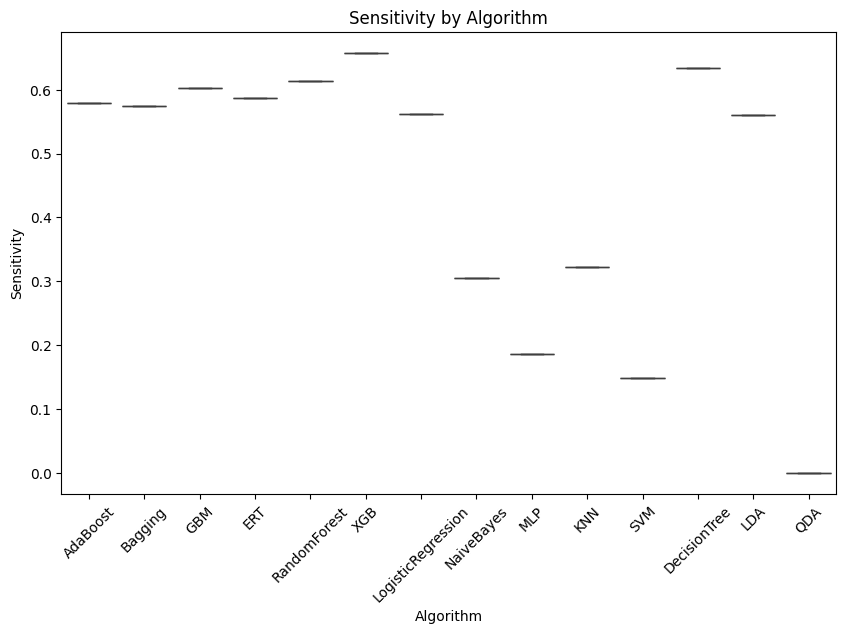

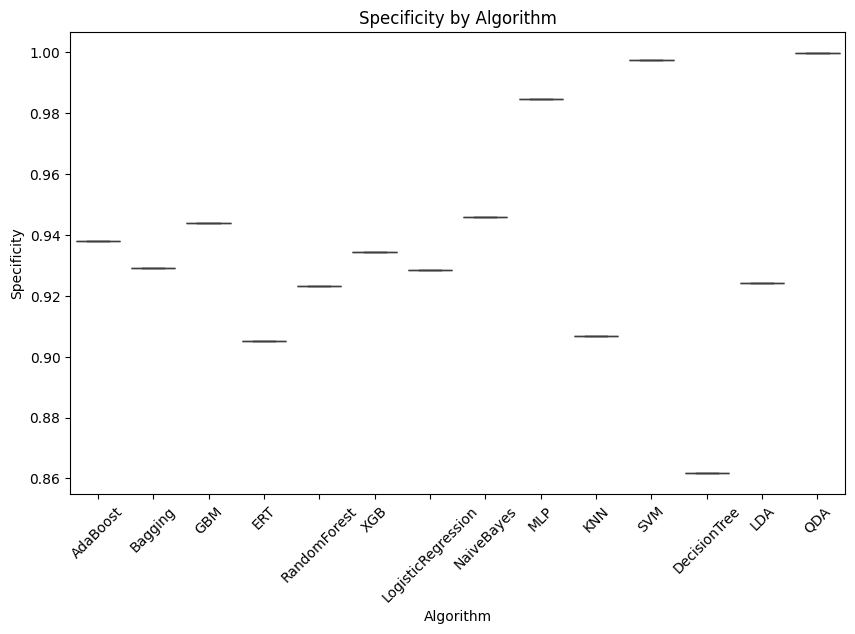

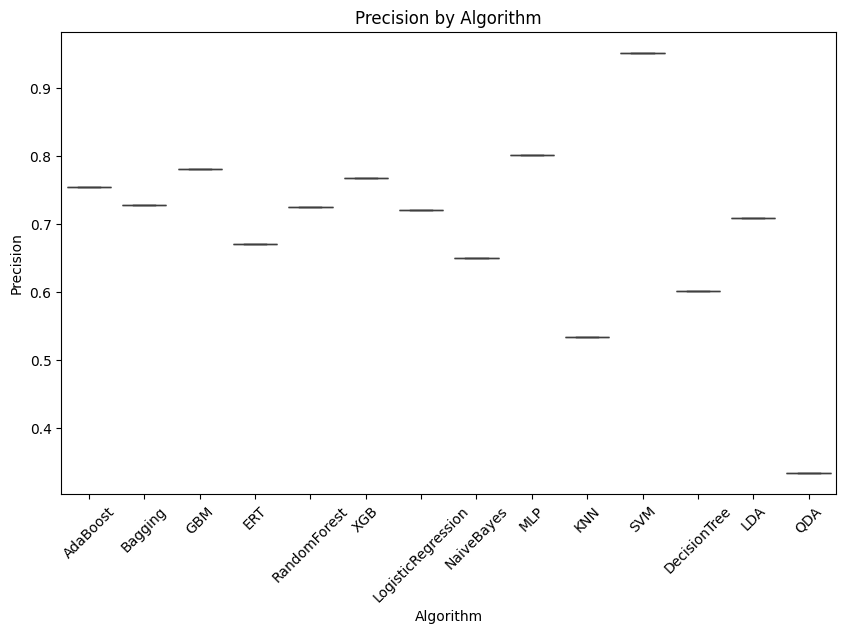

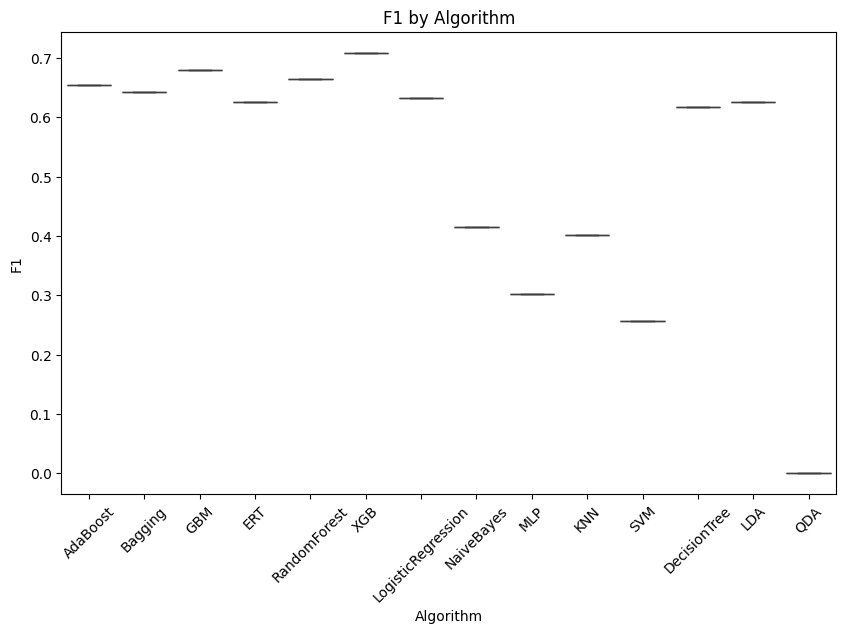

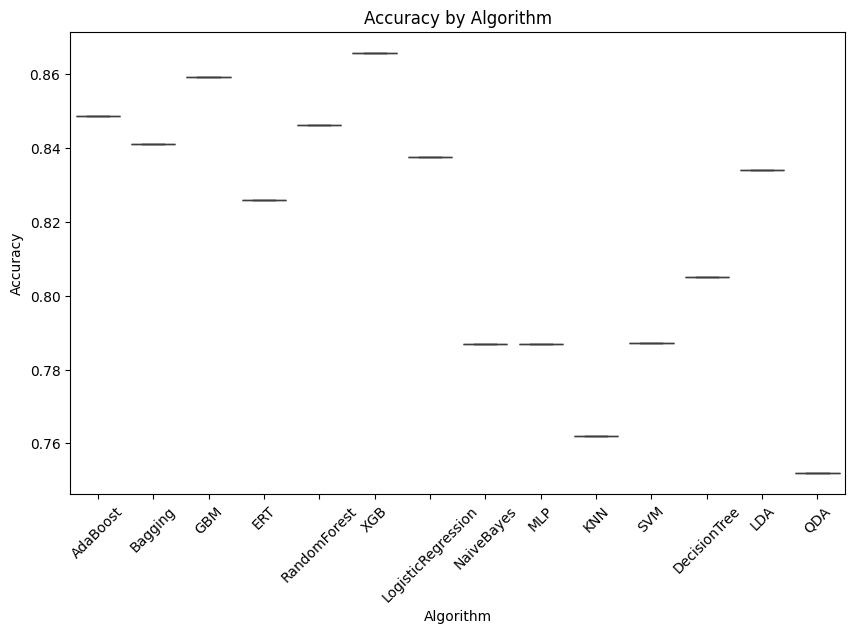

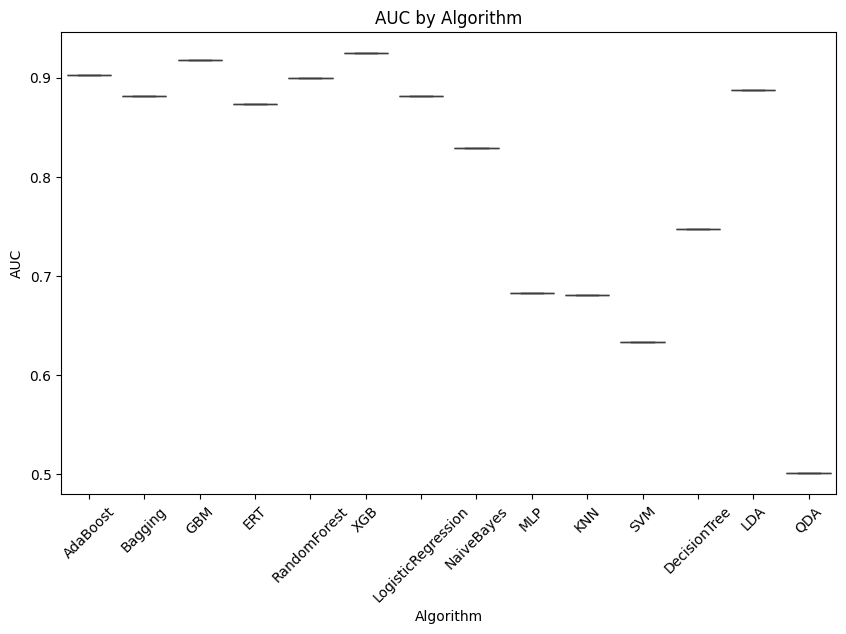

In [ ]:
# Paso 4: Métricas
def metricas(model, model_label, X_train, X_valid, y_train, y_valid):
    y_pred = model.predict(X_valid)
    try:
        y_pred_prob = model.predict_proba(X_valid)[:, 1]
    except AttributeError:
        y_pred_prob = y_pred

    cm = confusion_matrix(y_valid, y_pred)
    sensitivity = recall_score(y_valid, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    try:
        auc = roc_auc_score(y_valid, y_pred_prob)
    except:
        auc = np.nan

    return {
        'Algorithm': model_label,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1': f1,
        'Accuracy': accuracy,
        'AUC': auc
    }

# Paso 5: Modelos
models = {
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'GBM': GradientBoostingClassifier(),
    'ERT': ExtraTreesClassifier(),# Nuevo
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),#nuevo
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()    
}

# Entrenar modelos
results = []
X_train_np = np.ascontiguousarray(X_train.values)   
X_valid_np = np.ascontiguousarray(X_valid.values)

for model_label, model in models.items():
    model.fit(X_train_np, y_train)
    result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
    results.append(result)

df_results = pd.DataFrame(results)

# Paso 6: Visualización
metrics = ['Sensitivity', 'Specificity', 'Precision', 'F1', 'Accuracy', 'AUC']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Algorithm', y=metric, data=df_results)
    plt.title(f'{metric} by Algorithm')
    plt.xticks(rotation=45)
    plt.show()


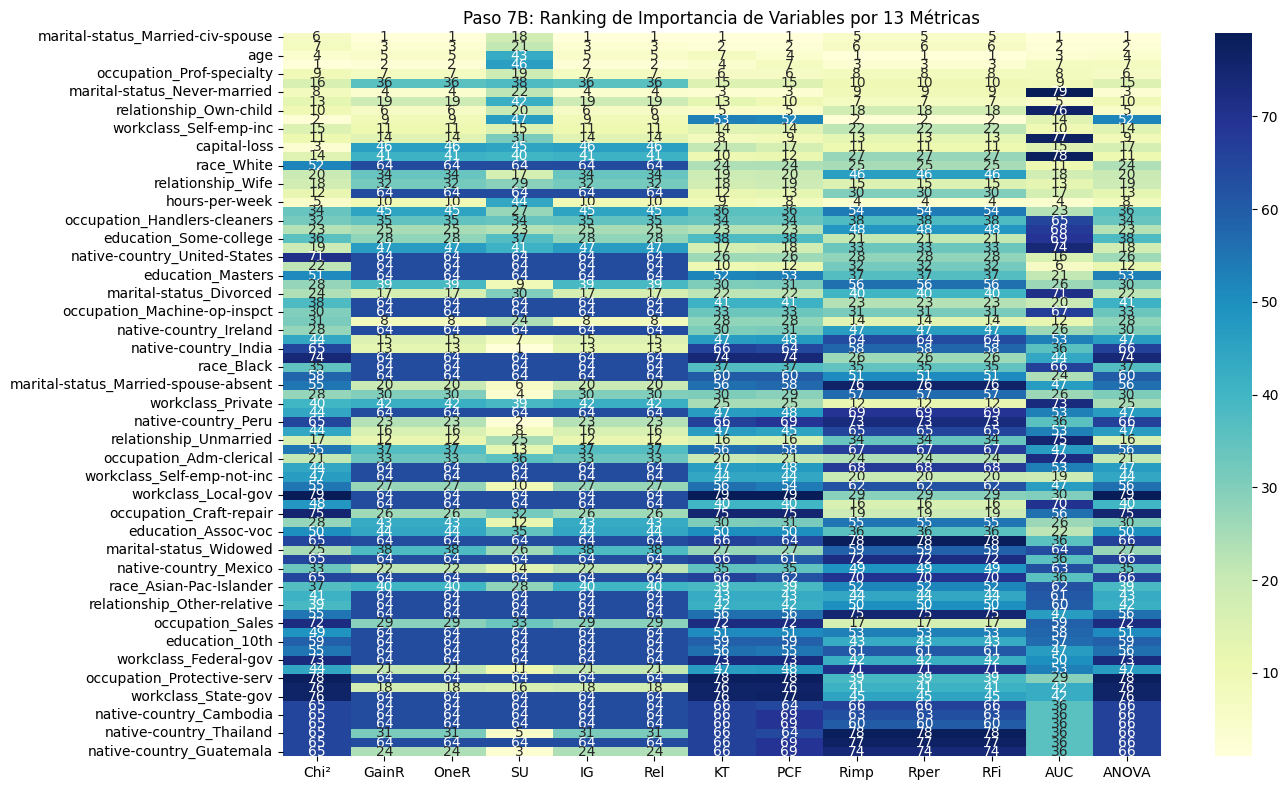

                                   Chi²  GainR  OneR    SU    IG   Rel    KT  \
marital-status_Married-civ-spouse   6.0    1.0   1.0  18.0   1.0   1.0   1.0   
relationship_Husband                7.0    3.0   3.0  21.0   3.0   3.0   2.0   
age                                 4.0    5.0   5.0  43.0   5.0   5.0   7.0   
capital-gain                        1.0    2.0   2.0  46.0   2.0   2.0   4.0   
occupation_Prof-specialty           9.0    7.0   7.0  19.0   7.0   7.0   6.0   
...                                 ...    ...   ...   ...   ...   ...   ...   
native-country_Vietnam             65.0   63.5  63.5  63.5  63.5  63.5  66.0   
native-country_South               65.0   63.5  63.5  63.5  63.5  63.5  66.0   
education_1st-4th                  65.0   63.5  63.5  63.5  63.5  63.5  66.0   
occupation_Armed-Forces            65.0   63.5  63.5  63.5  63.5  63.5  66.0   
native-country_Haiti               65.0   63.5  63.5  63.5  63.5  63.5  66.0   

                                    PCF

In [30]:
# Paso 7: Importancia de las características
X_imp = X.astype('float64')
y_imp = y

chi2_vals, _ = chi2(X_imp, y_imp)
mi_vals = mutual_info_classif(X_imp, y_imp)
anova_vals, _ = f_classif(X_imp, y_imp)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_imp, y_imp)
rfi_vals = rf.feature_importances_

auc_vals = [roc_auc_score(y_imp, X_imp[col]) if len(np.unique(X_imp[col])) > 1 else np.nan for col in X_imp.columns]
kt_vals = [abs(kendalltau(X_imp[col], y_imp).correlation) for col in X_imp.columns]
pcf_vals = [abs(pointbiserialr(X_imp[col], y_imp)[0]) for col in X_imp.columns]

# Aproximaciones
gainr_vals = mi_vals
oner_vals = mi_vals
su_vals = mi_vals / (X_imp.var().values + 1e-6)
rel_vals = mi_vals
rimp_vals = rfi_vals
rper_vals = rfi_vals

importancia_df = pd.DataFrame({
    'Chi²': chi2_vals,
    'GainR': gainr_vals,
    'OneR': oner_vals,
    'SU': su_vals,
    'IG': mi_vals,
    'Rel': rel_vals,
    'KT': kt_vals,
    'PCF': pcf_vals,
    'Rimp': rimp_vals,
    'Rper': rper_vals,
    'RFi': rfi_vals,
    'AUC': auc_vals,
    'ANOVA': anova_vals
}, index=X_imp.columns)

# Paso 7B: Ranking
ranking_df = importancia_df.rank(ascending=False)
ranking_df['Mean'] = ranking_df.mean(axis=1)
ranking_df['Rank'] = ranking_df['Mean'].rank()

# Visualización del ranking
plt.figure(figsize=(14, 8))
sns.heatmap(ranking_df.iloc[:, :-2], annot=True, cmap='YlGnBu')
plt.title("Paso 7B: Ranking de Importancia de Variables por 13 Métricas")
plt.tight_layout()
plt.show()

# Mostrar top variables
print(ranking_df.sort_values("Rank"))


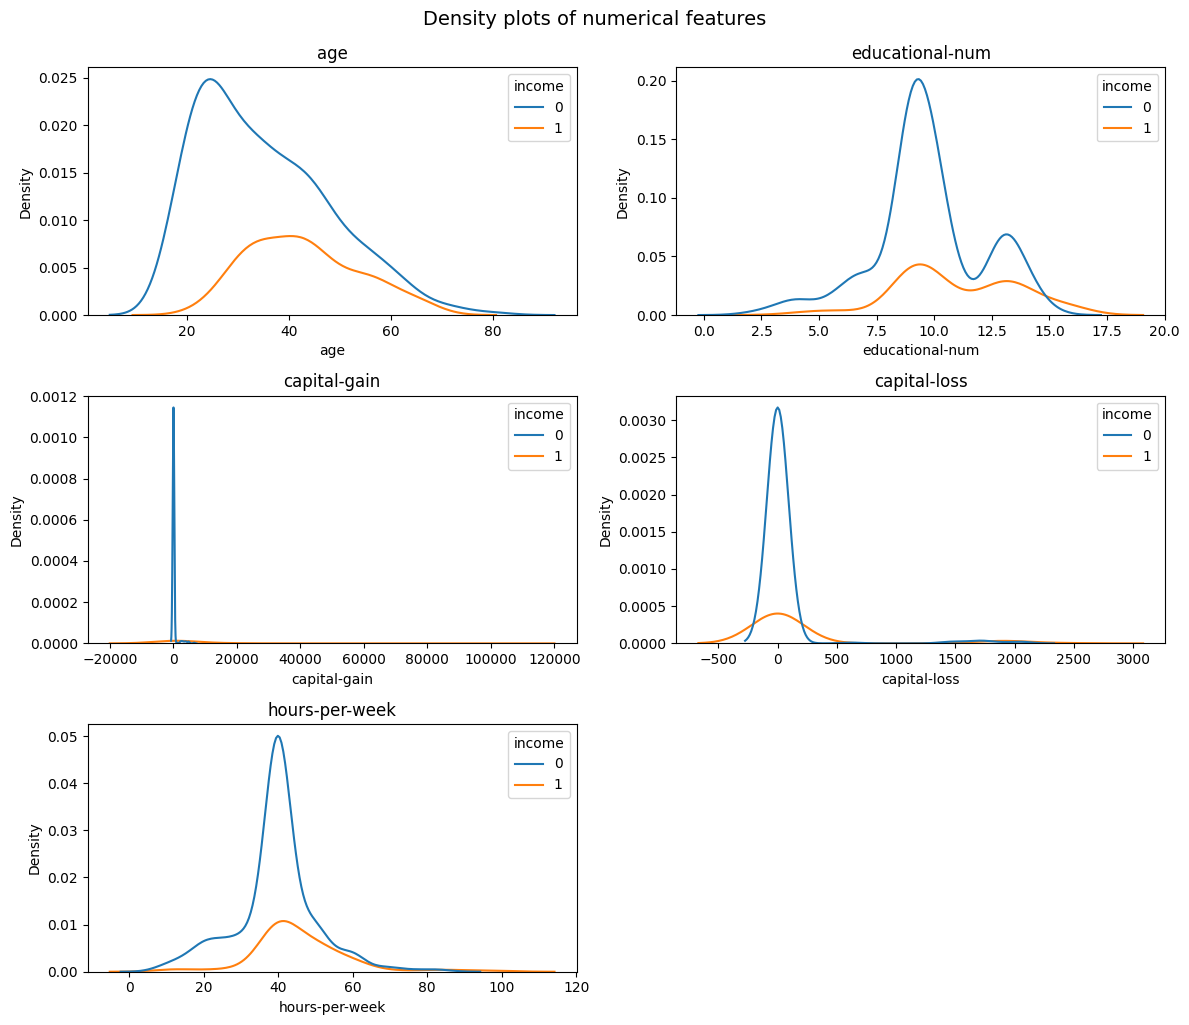

In [8]:
# Paso 7C: Gráficos de densidad de variables numéricas por clase
numerical_features = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=df, x=col, hue='income', fill=False)
    plt.title(col)

plt.tight_layout()
plt.suptitle("Density plots of numerical features", fontsize=14, y=1.02)
plt.show()



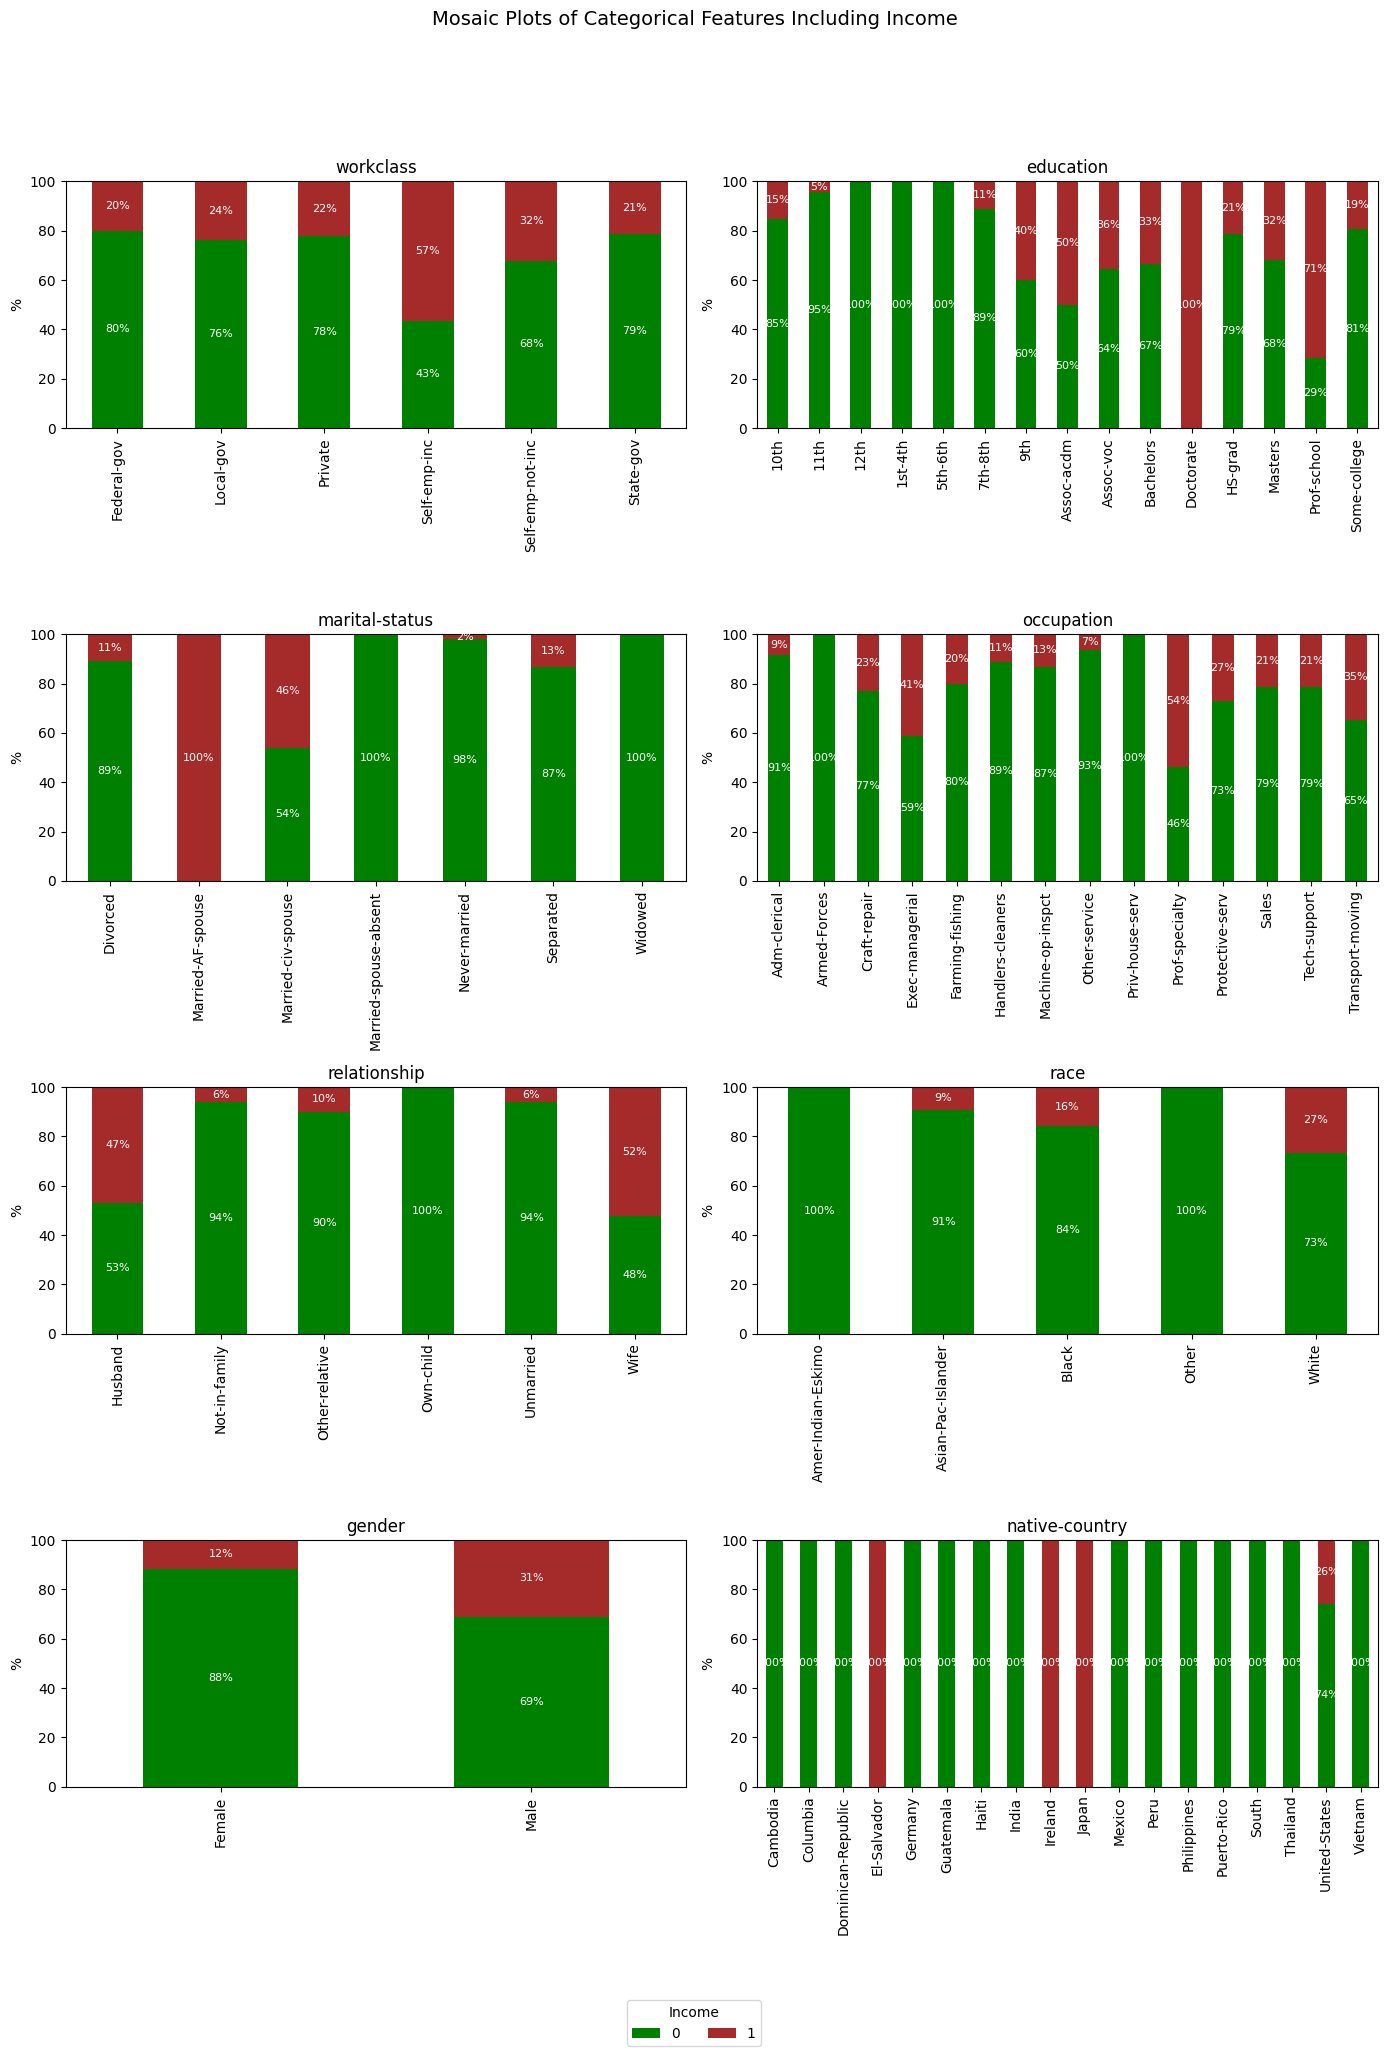

In [9]:
# Paso 7D: Gráficos de mosaico para variables categóricas incluyendo income
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
df_mosaic = df.copy()

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    prop_df = pd.crosstab(df_mosaic[col], df_mosaic['income'], normalize='index') * 100
    prop_df.plot(kind='bar', stacked=True, ax=ax, color=['green', 'brown'], legend=False)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2.,
                    f'{height:.0f}%', ha="center", va="center", color='white', fontsize=8)
    ax.set_title(col)
    ax.set_ylabel('%')
    ax.set_xlabel('')
    ax.set_ylim(0, 100)

# Eliminar ejes sobrantes si los hay
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Income", loc='lower center', ncol=2)
plt.suptitle('Mosaic Plots of Categorical Features Including Income', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()



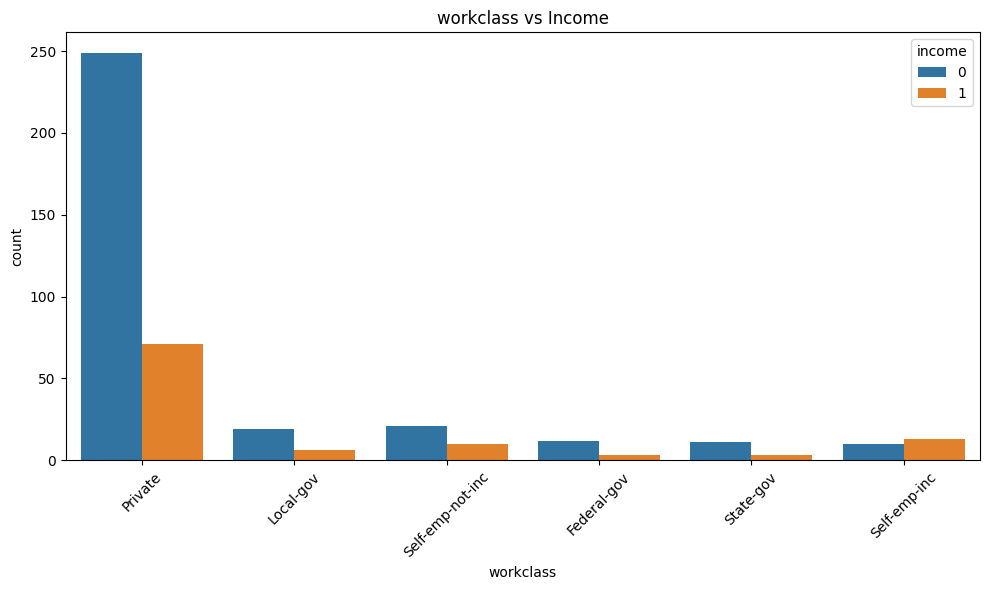

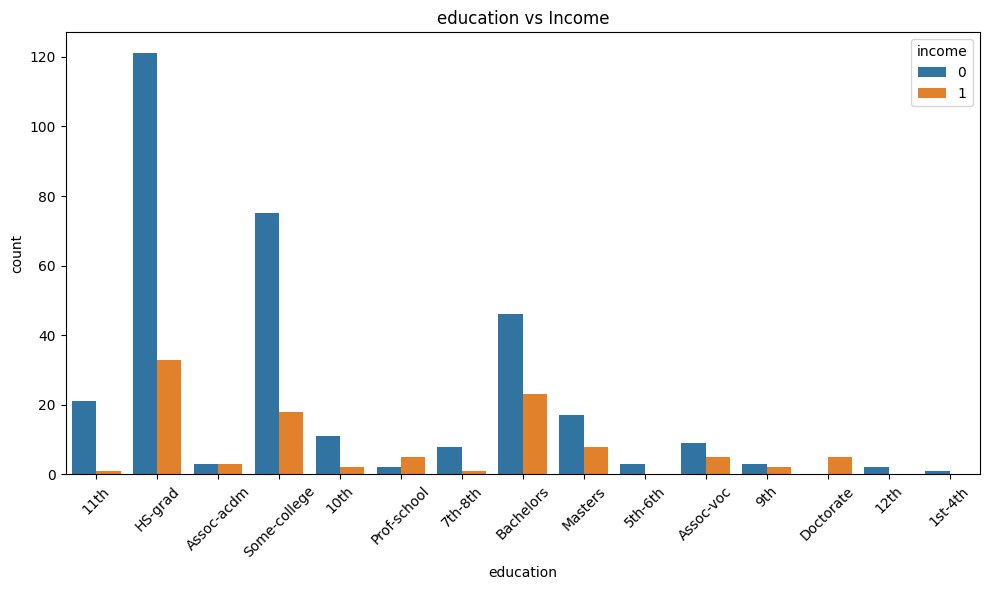

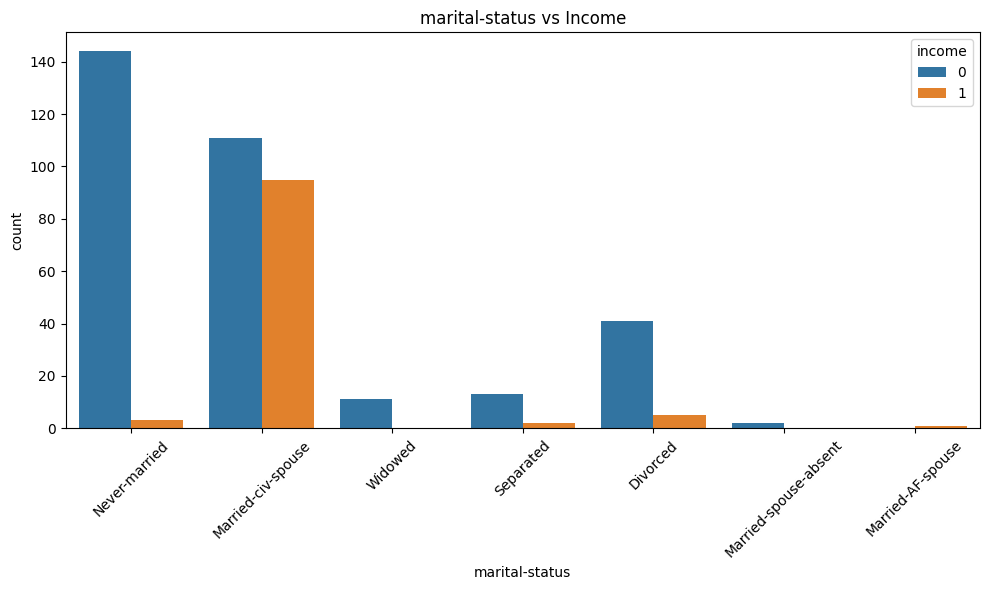

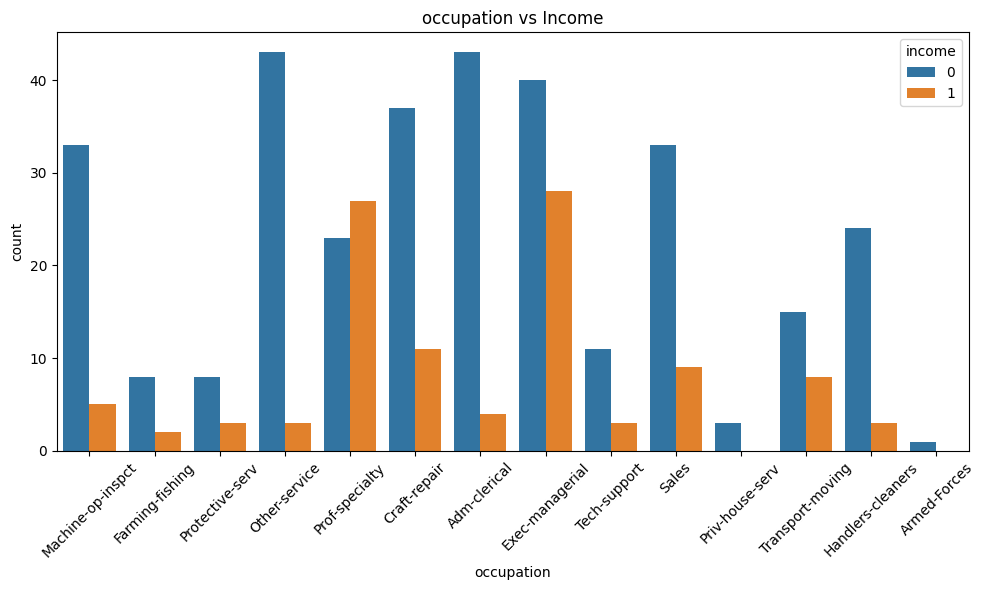

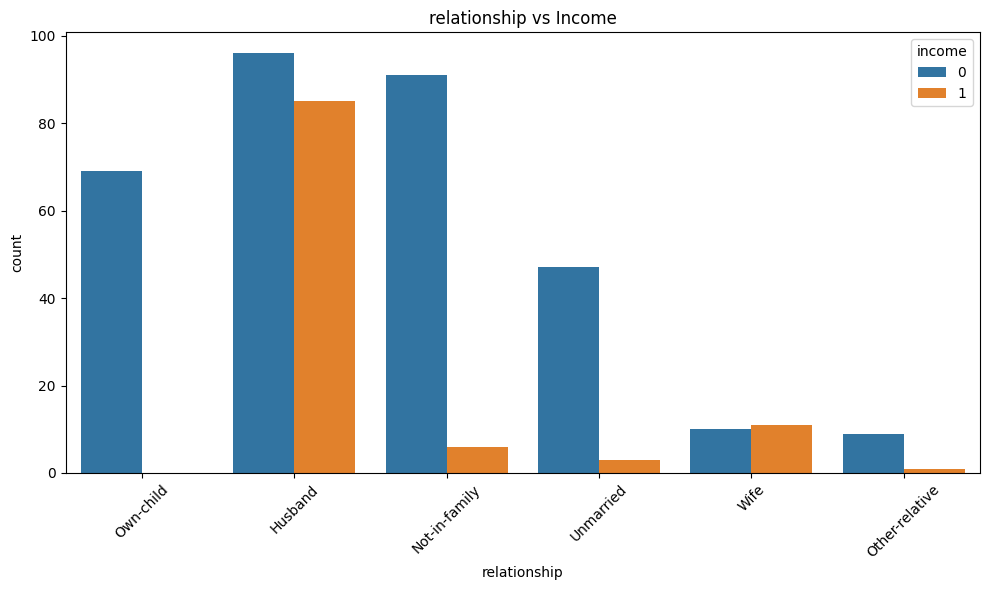

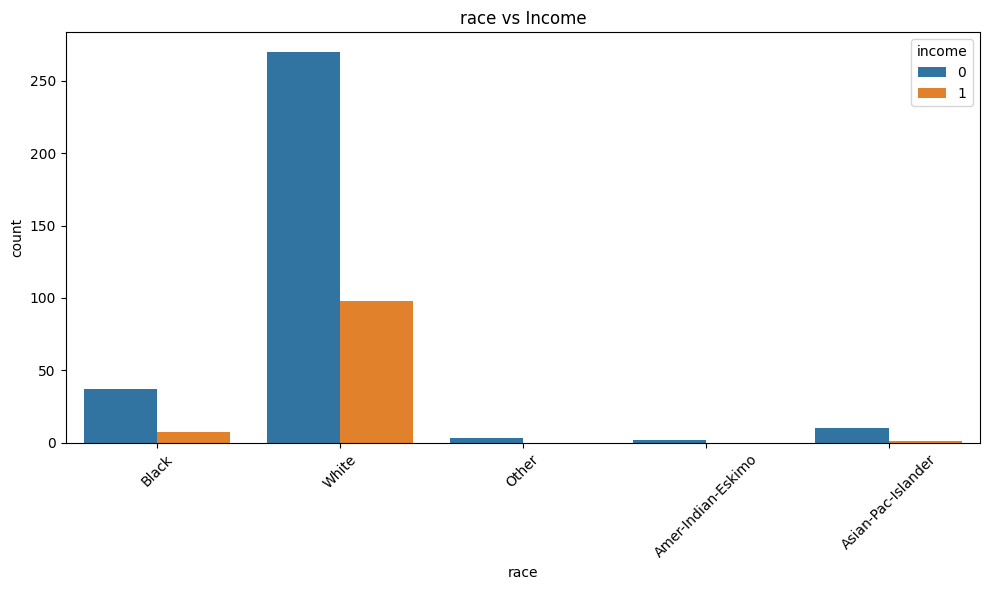

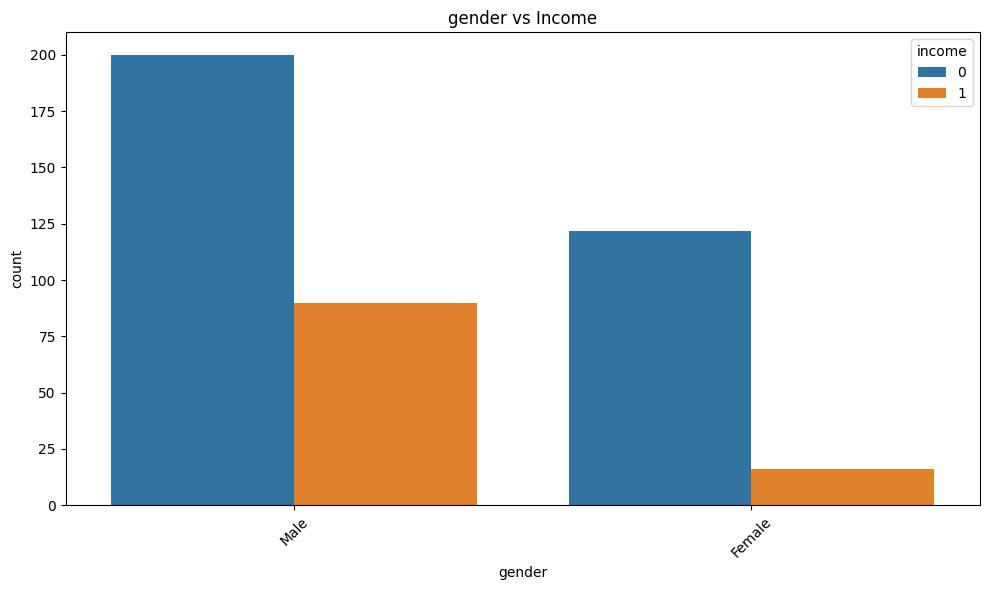

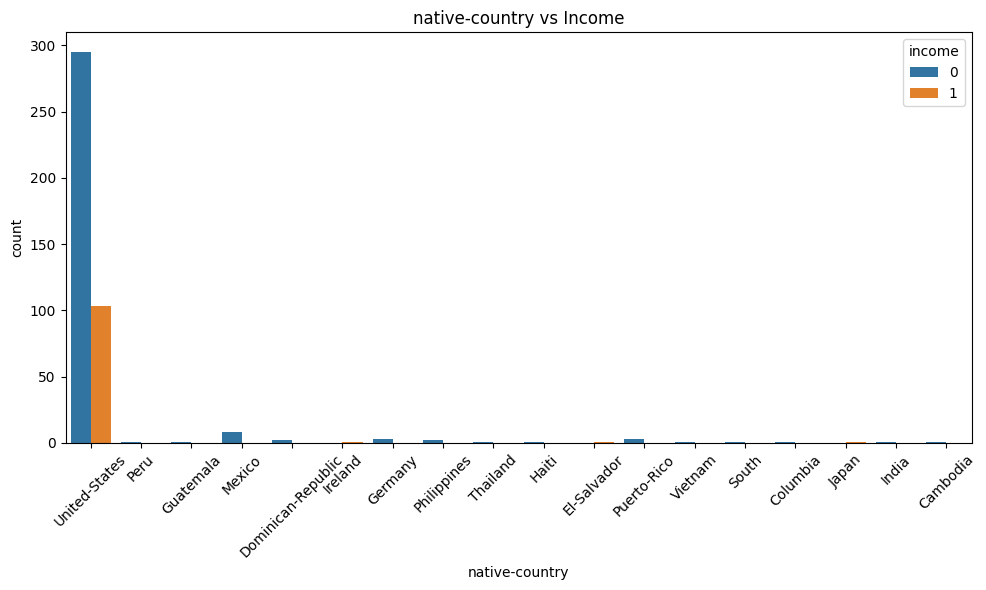

In [10]:
# Paso 8: Gráficos de variables categóricas vs income
df_vis = df.copy()
df_vis['income'] = df_vis['income'].astype(str)

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='income', data=df_vis)
    plt.title(f'{col} vs Income')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

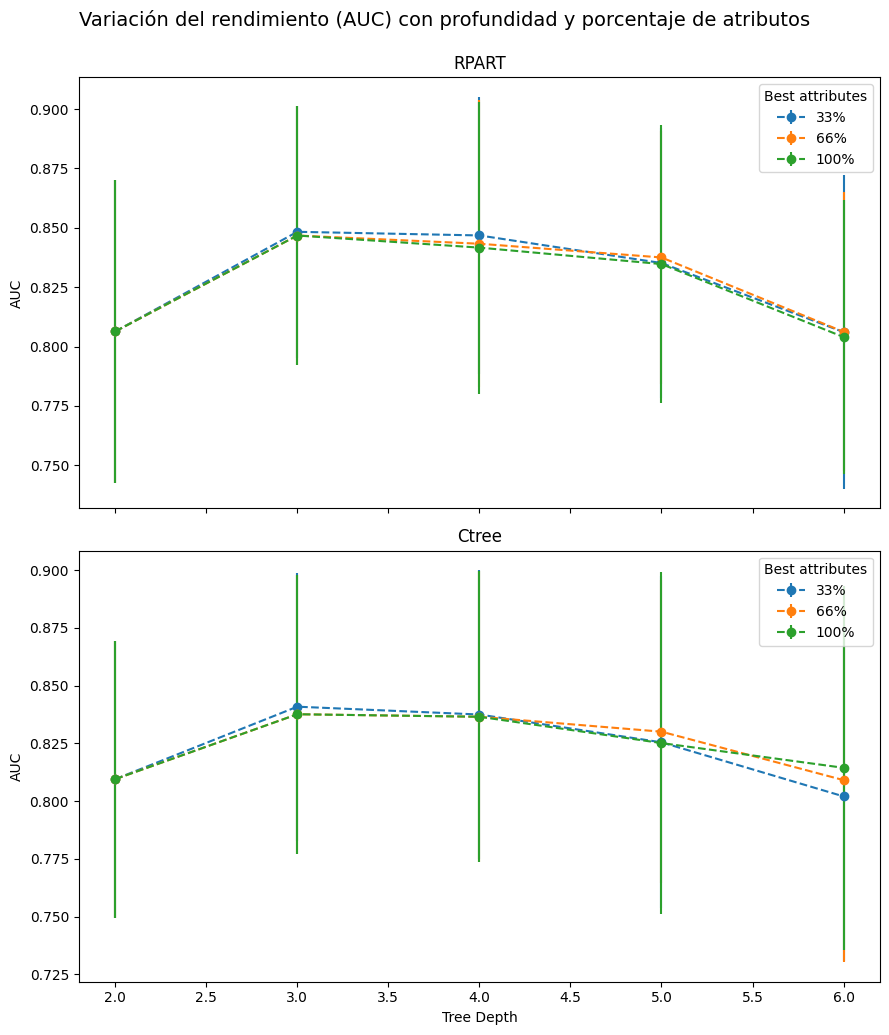

In [ ]:
# Paso 8.1: Rendimiento (AUC) con profundidad y porcentaje de atributos basado en ranking
ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)

top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()
top_66 = ranking_sorted.head(int(total_features * 0.66)).index.tolist()
top_100 = ranking_sorted.index.tolist()

df_vis = df_encoded.copy()
df_vis['income'] = y

attribute_sets = {
    '33%': df_vis[top_33 + ['income']],
    '66%': df_vis[top_66 + ['income']],
    '100%': df_vis[top_100 + ['income']]
}

depths = [2, 3, 4, 5, 6]
results_rpart = []
results_ctree = []

for name, dataset in attribute_sets.items():
    X = dataset.drop('income', axis=1)
    y = dataset['income']

    for depth in depths:
        rpart = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=42)
        rpart_scores = cross_val_score(rpart, X, y, cv=5, scoring='roc_auc')
        results_rpart.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(rpart_scores),
            'Std': np.std(rpart_scores)
        })

        ctree = DecisionTreeClassifier(max_depth=depth, criterion='importancia', random_state=42)
        ctree_scores = cross_val_score(ctree, X, y, cv=5, scoring='roc_auc')
        results_ctree.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(ctree_scores),
            'Std': np.std(ctree_scores)
        })

rpart_df = pd.DataFrame(results_rpart)
ctree_df = pd.DataFrame(results_ctree)

fig, axes = plt.subplots(2, 1, figsize=(9, 10), sharex=True)

for subset in rpart_df['Subset'].unique():
    data = rpart_df[rpart_df['Subset'] == subset]
    axes[0].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[0].set_title("RPART")
axes[0].set_ylabel("AUC")
axes[0].legend(title="Best attributes")

for subset in ctree_df['Subset'].unique():
    data = ctree_df[ctree_df['Subset'] == subset]
    axes[1].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[1].set_title("Ctree")
axes[1].set_xlabel("Tree Depth")
axes[1].set_ylabel("AUC")
axes[1].legend(title="Best attributes")

plt.tight_layout()
plt.suptitle("Variación del rendimiento (AUC) con profundidad y porcentaje de atributos", fontsize=14, y=1.03)
plt.show()


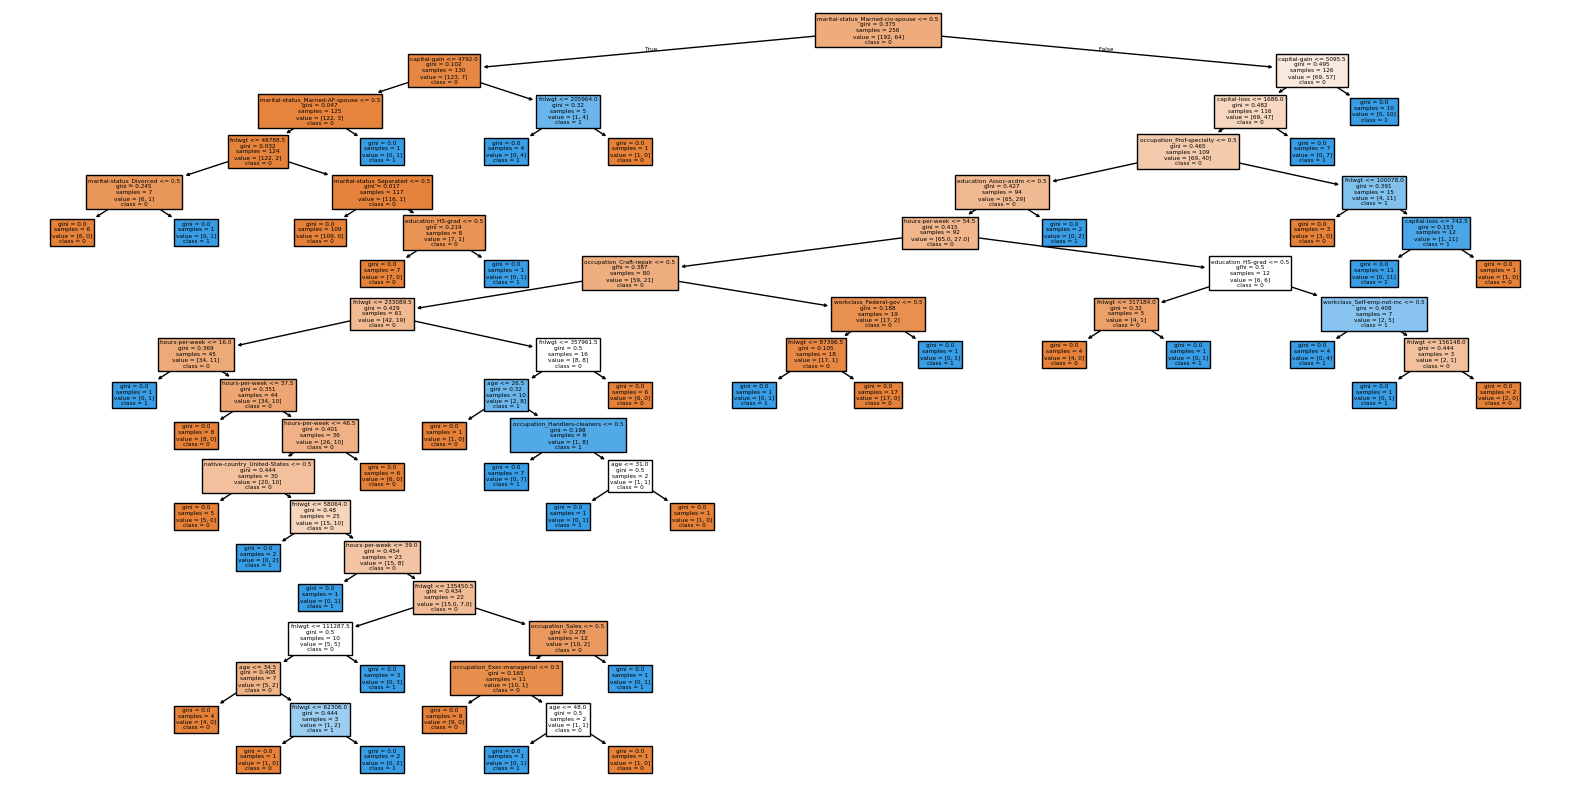

In [12]:
# Paso 9: Árbol de decisión
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=list(X_train.columns), class_names=['0', '1'])
plt.show()

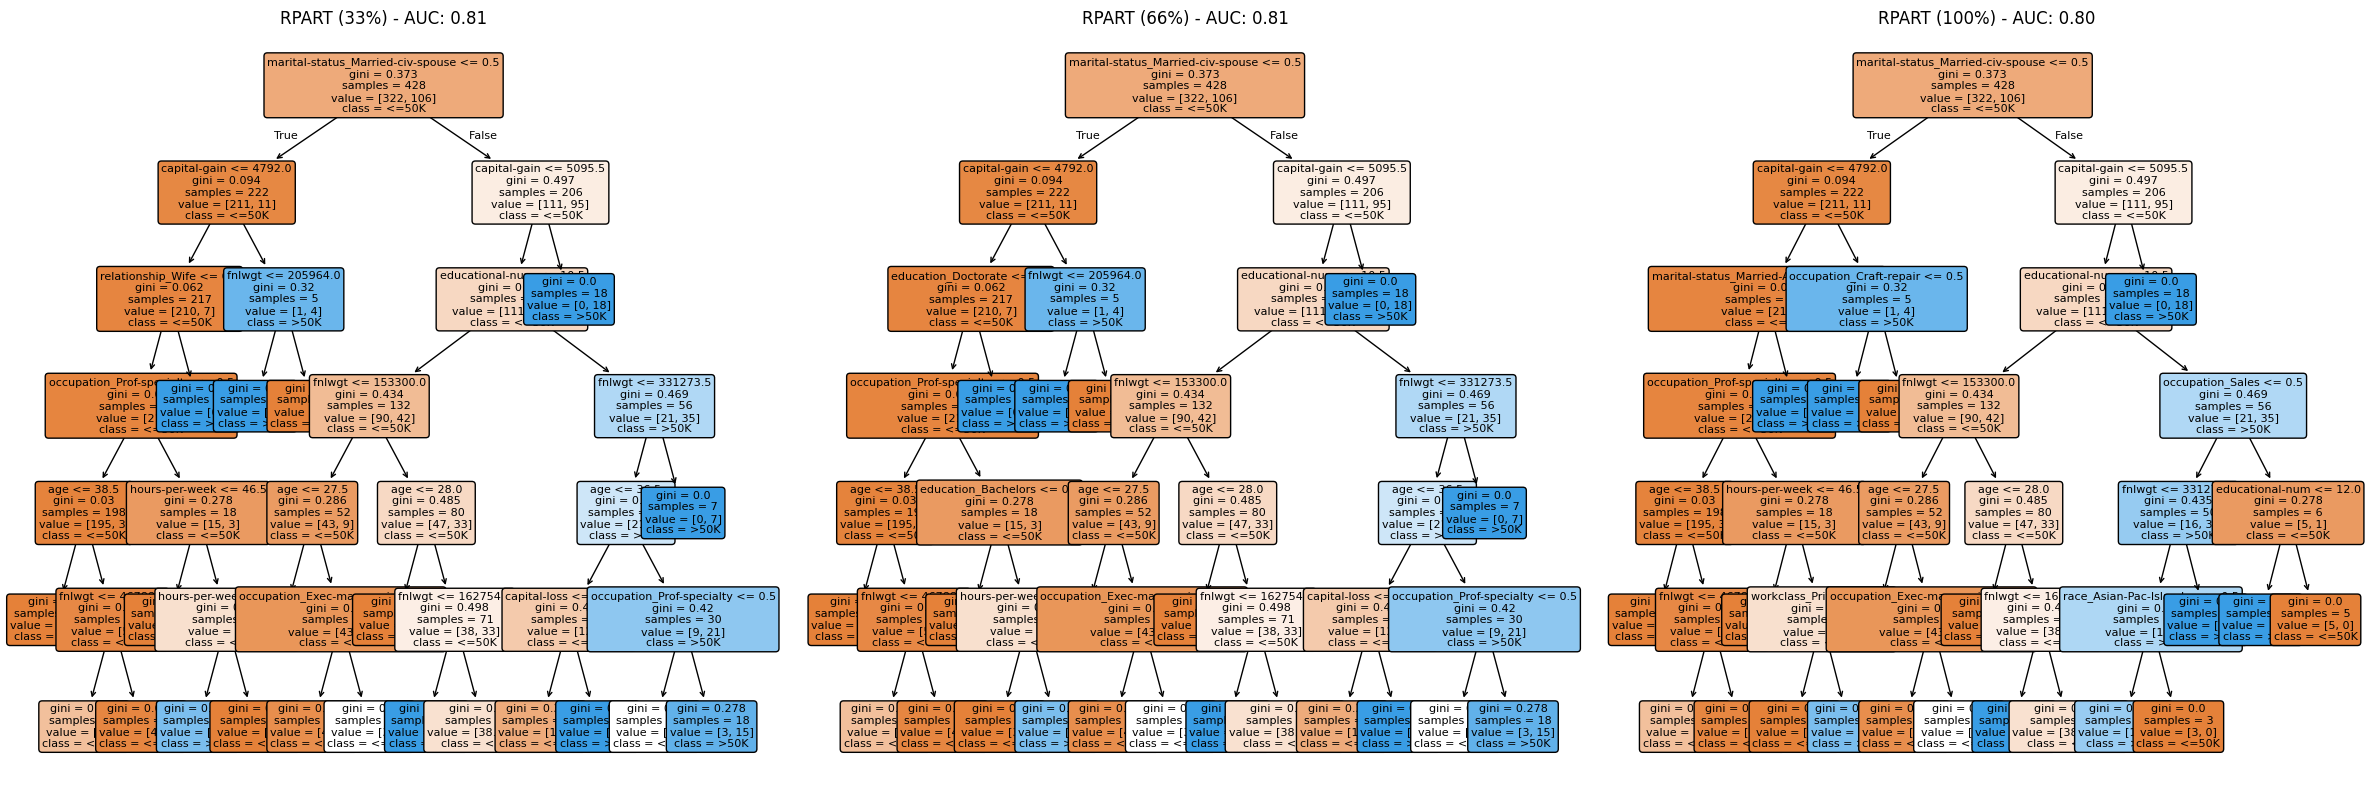

In [13]:
# Paso 9.1: Visualización de RPART con 33%, 66% y 100% de características (max_depth=6)
ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)

top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()
top_66 = ranking_sorted.head(int(total_features * 0.66)).index.tolist()
top_100 = ranking_sorted.index.tolist()

df_vis = df_encoded.copy()
df_vis['income'] = y

attribute_sets = {
    '33%': df_vis[top_33 + ['income']],
    '66%': df_vis[top_66 + ['income']],
    '100%': df_vis[top_100 + ['income']]
}

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
rpart_auc_scores = {}

for ax, (name, dataset) in zip(axes, attribute_sets.items()):
    X_plot = dataset.drop('income', axis=1)
    y_plot = dataset['income']

    model = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
    model.fit(X_plot, y_plot)

    auc = cross_val_score(model, X_plot, y_plot, cv=5, scoring='roc_auc').mean()
    rpart_auc_scores[name] = auc

    plot_tree(
        model,
        feature_names=list(X_plot.columns),
        class_names=['<=50K', '>50K'],
        filled=True,
        rounded=True,
        fontsize=8,
        ax=ax
    )
    ax.set_title(f"RPART ({name}) - AUC: {auc:.2f}")

plt.tight_layout()
plt.show()



In [34]:
# Paso extra: Visualización de árbol RPART con 33% de características más importantes (fuera del paso 10)
import re
from sklearn.tree import export_graphviz
import graphviz

# Paso extra: Visualización de árbol RPART con 33% de características más importantes (fuera del paso 10)
ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)
top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()

df_vis = df_encoded.copy()
df_vis['income'] = y

X_33 = df_vis[top_33]
y_33 = df_vis['income']

model_33 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_33.fit(X_33, y_33)

# Limpiar nombres para Graphviz
def clean_column(col):
    return re.sub(r'[^a-zA-Z0-9_]', '_', col)

clean_feature_names_33 = [clean_column(col) for col in X_33.columns]

# Exportar y visualizar
dot_data_33 = export_graphviz(
    model_33,
    out_file=None,
    feature_names=clean_feature_names_33,
    class_names=['low', 'high'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph_33 = graphviz.Source(dot_data_33)
graph_33.render("tree_33", format="png", cleanup=False)
graph_33.view()

'tree_33.pdf'

In [35]:
# Árbol 66%
X_66 = df_vis[top_66]
y_66 = df_vis['income']
model_66 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_66.fit(X_66, y_66)
clean_feature_names_66 = [clean_column(col) for col in X_66.columns]
dot_data_66 = export_graphviz(
    model_66,
    out_file=None,
    feature_names=clean_feature_names_66,
    class_names=['low', 'high'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph_66 = graphviz.Source(dot_data_66)
graph_66.render("tree_66", format="png", cleanup=False)
graph_66.view()

'tree_66.pdf'

In [36]:
# Árbol 100%
X_100 = df_vis[top_100]
y_100 = df_vis['income']
model_100 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_100.fit(X_100, y_100)
clean_feature_names_100 = [clean_column(col) for col in X_100.columns]
dot_data_100 = export_graphviz(
    model_100,
    out_file=None,
    feature_names=clean_feature_names_100,
    class_names=['low', 'high'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph_100 = graphviz.Source(dot_data_100)
graph_100.render("tree_100", format="png", cleanup=False)
graph_100.view()



'tree_100.pdf'

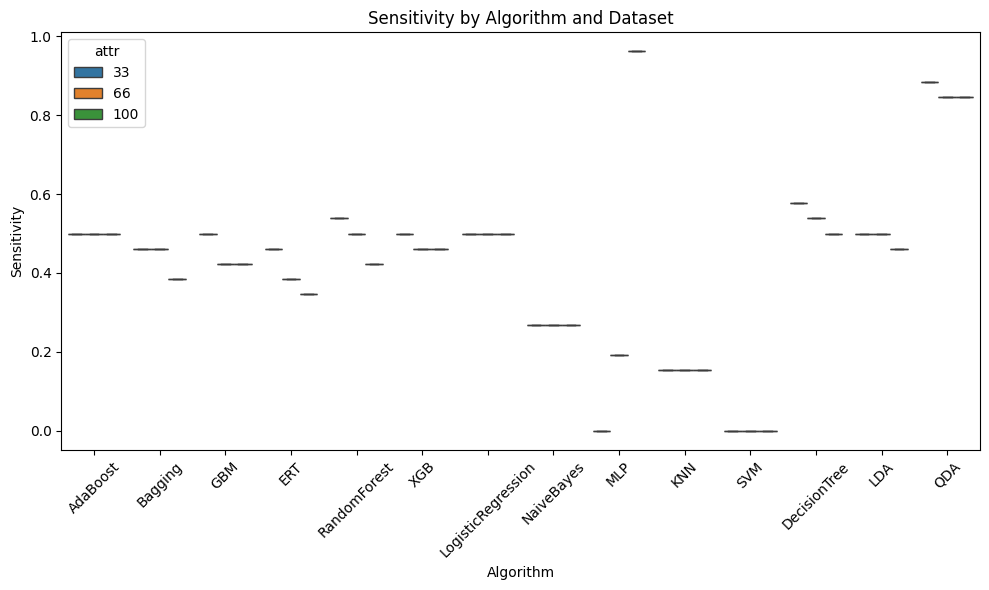

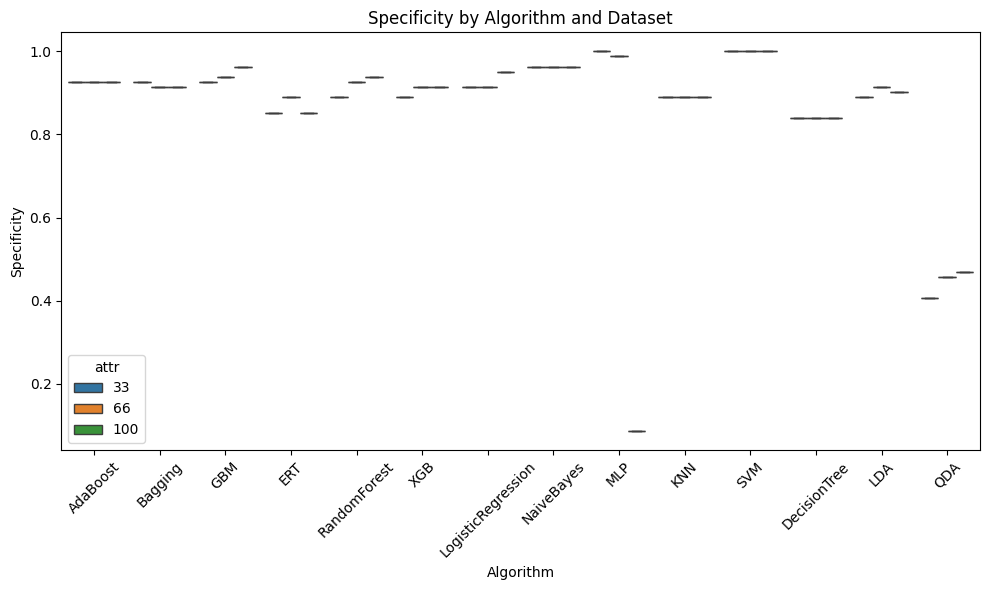

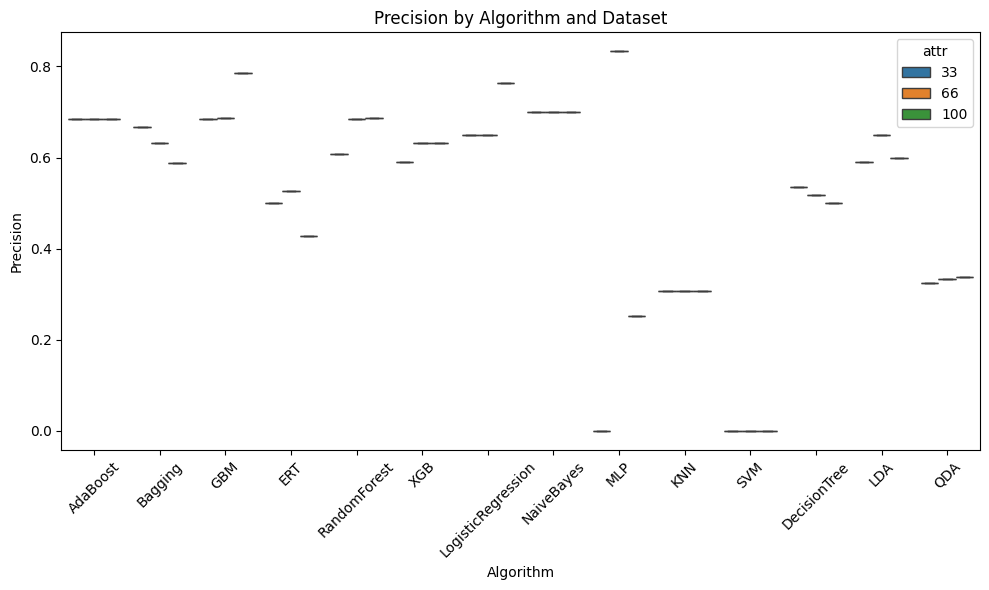

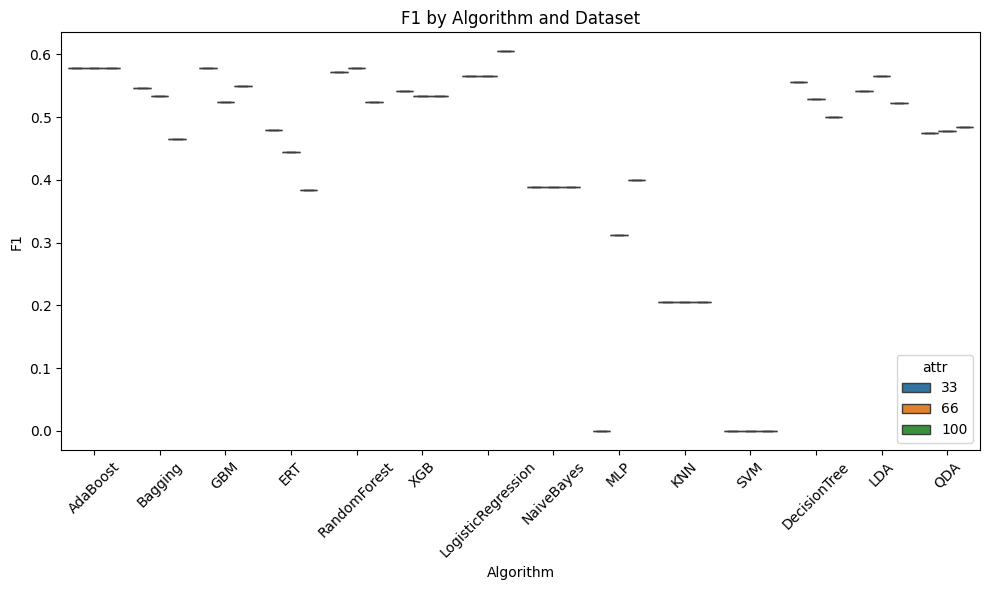

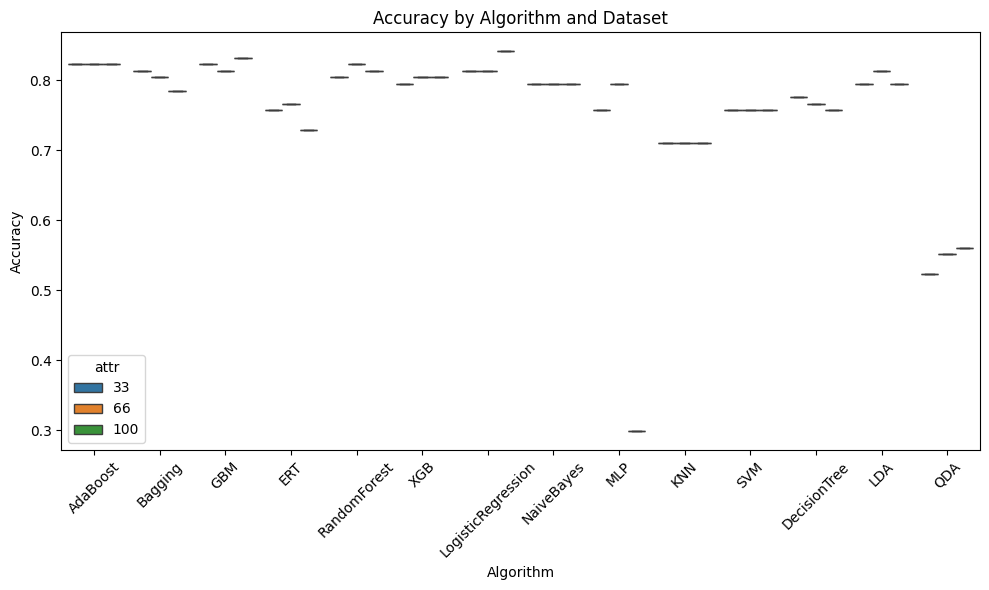

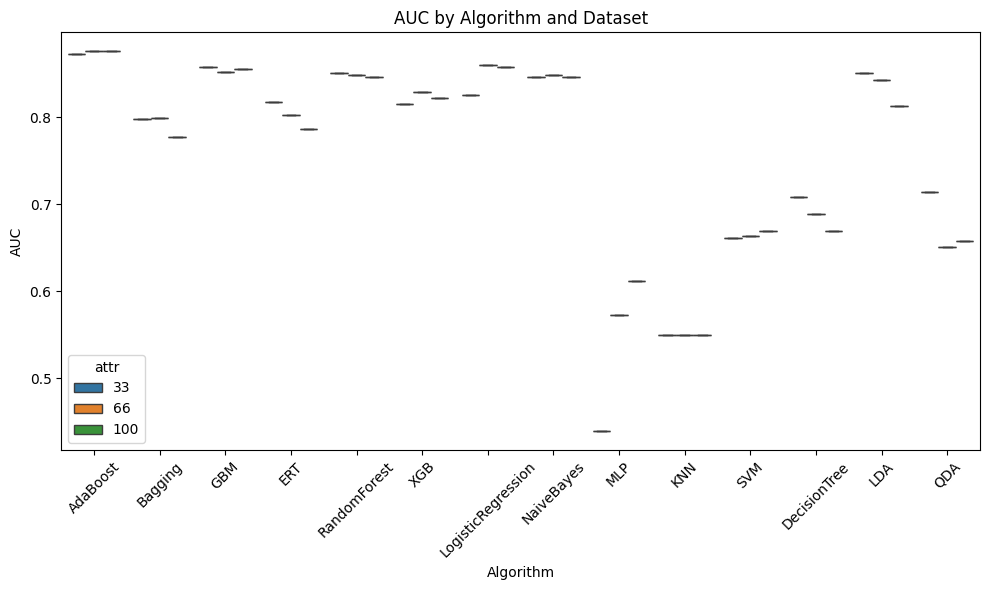

In [37]:
# Paso 10: Evaluación con conjuntos de datos distintos (33%, 66% y 100%)

ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)
top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()
top_66 = ranking_sorted.head(int(total_features * 0.66)).index.tolist()
top_100 = ranking_sorted.index.tolist()

df_vis = df_encoded.copy()
df_vis['income'] = y

# Preparar datasets

df_33 = df_vis[top_33 + ['income']]
df_66 = df_vis[top_66 + ['income']]
df_100 = df_vis[top_100 + ['income']]

datasets = {'33': df_33, '66': df_66, '100': df_100}
results_all = []

for name, dataset in datasets.items():
    X = dataset.drop('income', axis=1)
    y = dataset['income']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    X_train_np = np.ascontiguousarray(X_train.values)
    X_valid_np = np.ascontiguousarray(X_valid.values)

    for model_label, model in models.items():
        model.fit(X_train_np, y_train)
        result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
        result['attr'] = name
        results_all.append(result)

df_results_all = pd.DataFrame(results_all)

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Algorithm', y=metric, hue='attr', data=df_results_all)
    plt.title(f'{metric} by Algorithm and Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

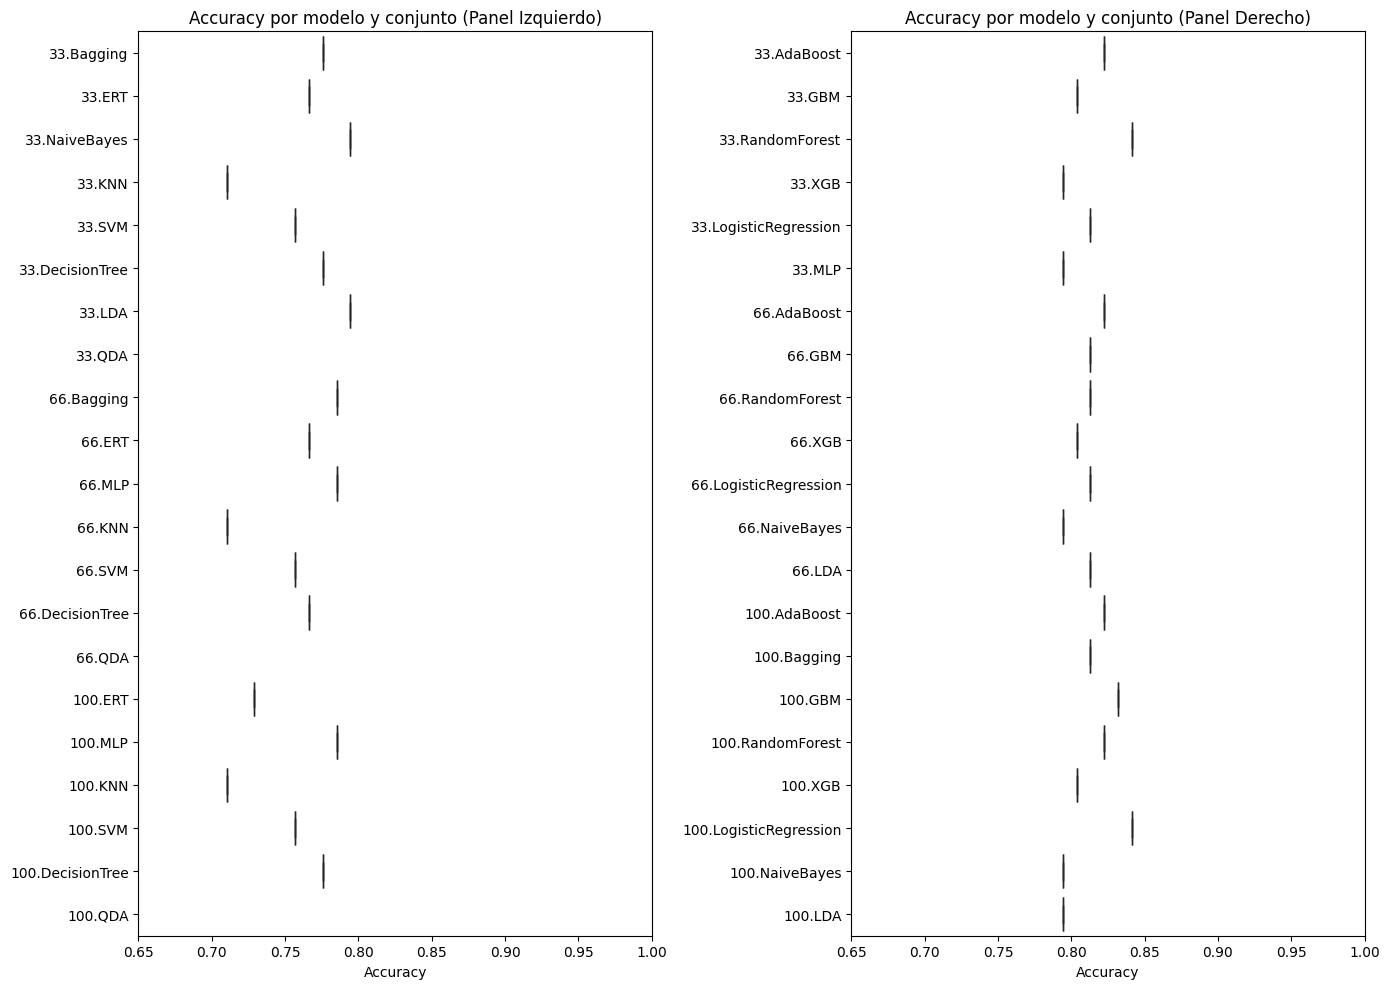

In [38]:

import matplotlib.gridspec as gridspec
# Paso 10.1: Evaluación con conjuntos de datos distintos y visualización tipo boxplot para Accuracy
ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)
top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()
top_66 = ranking_sorted.head(int(total_features * 0.66)).index.tolist()
top_100 = ranking_sorted.index.tolist()

df_vis = df_encoded.copy()
df_vis['target'] = y

df_33 = df_vis[top_33 + ['target']]
df_66 = df_vis[top_66 + ['target']]
df_100 = df_vis[top_100 + ['target']]

datasets = {'33': df_33, '66': df_66, '100': df_100}
results_all = []

for name, dataset in datasets.items():
    X = dataset.drop('target', axis=1)
    y = dataset['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
    X_train_np = np.ascontiguousarray(X_train.values)
    X_valid_np = np.ascontiguousarray(X_valid.values)

    for model_label, model in models.items():
        model.fit(X_train_np, y_train)
        result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
        result['attr'] = name
        results_all.append(result)

# Crear DataFrame consolidado
df_results_all = pd.DataFrame(results_all)

# Crear clave de algoritmo + atributo para agrupamiento visual
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33': 'red', '66': 'green', '100': 'blue'})

# Gráfico tipo panel como la imagen de referencia
metric = 'Accuracy'
sorted_labels = df_results_all.groupby('Label')[metric].mean().sort_values().index

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half*i:half*(i+1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]
    sns.boxplot(
        data=subset,
        y='Label',
        x=metric,
        hue='attr',
        orient='h',
        ax=ax,
        palette={'33': 'red', '66': 'green', '100': 'blue'}
    )
    ax.set_xlim(0.65, 1.0)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('')
    ax.set_title(f'Accuracy por modelo y conjunto ({"Panel Izquierdo" if i == 0 else "Panel Derecho"})')
    ax.legend_.remove()

plt.tight_layout()
plt.show()



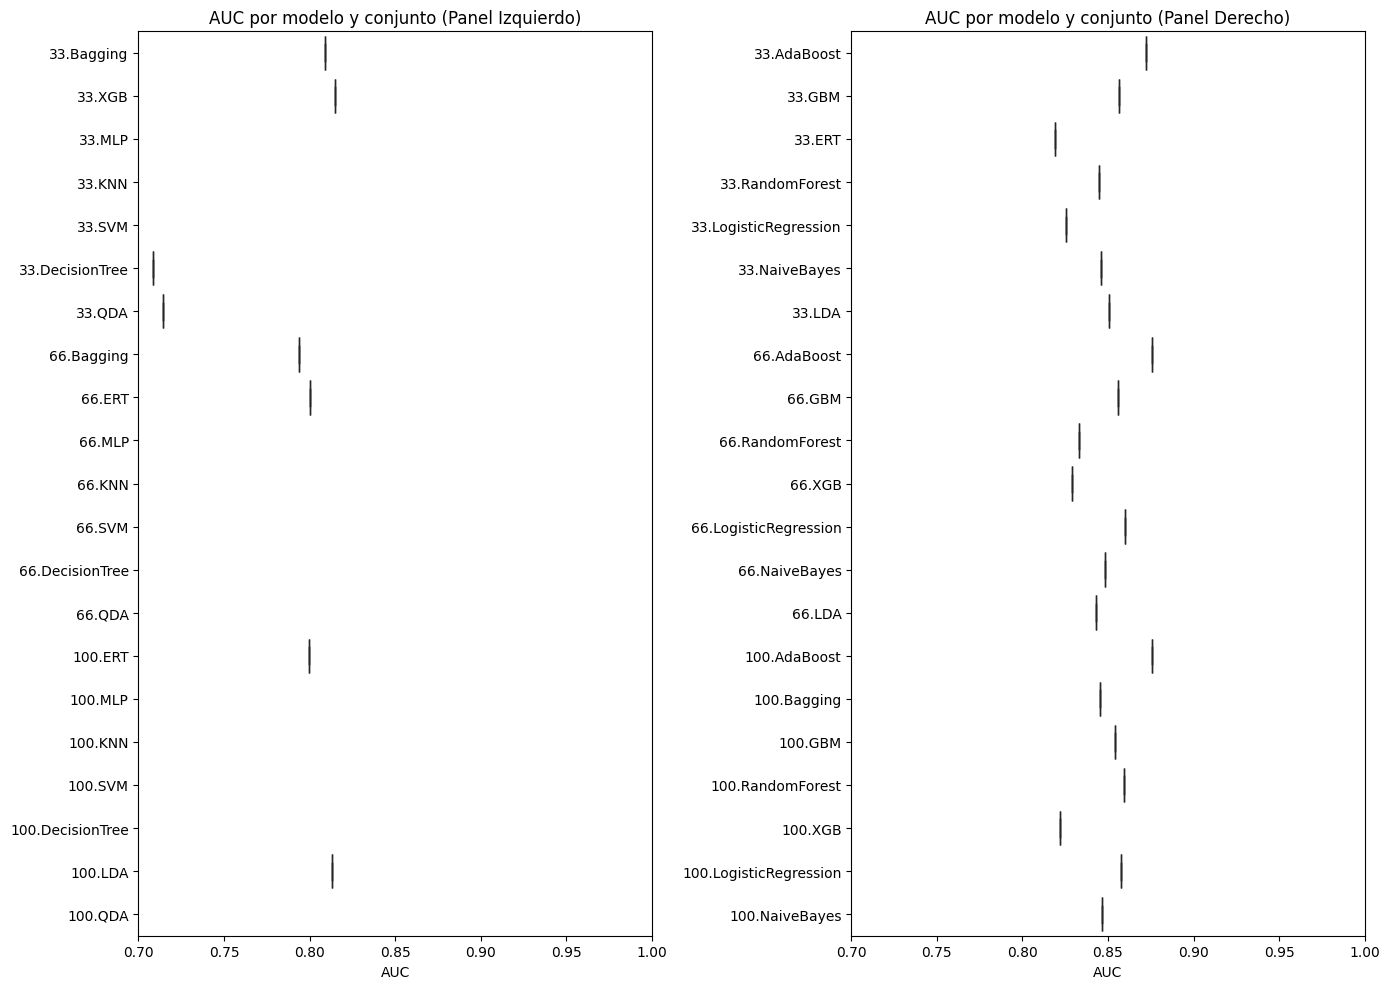

In [39]:
   # Paso final: Visualización tipo panel de AUC por modelo y conjunto de atributos (33, 66, 100)
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33': 'red', '66': 'green', '100': 'blue'})

metric = 'AUC'
sorted_labels = df_results_all.groupby('Label')[metric].mean().sort_values().index

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half*i:half*(i+1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]
    sns.boxplot(
        data=subset,
        y='Label',
        x=metric,
        hue='attr',
        orient='h',
        ax=ax,
        palette={'33': 'red', '66': 'green', '100': 'blue'}
    )
    ax.set_xlim(0.7, 1.0)
    ax.set_xlabel('AUC')
    ax.set_ylabel('')
    ax.set_title(f'AUC por modelo y conjunto ({"Panel Izquierdo" if i == 0 else "Panel Derecho"})')
    ax.legend_.remove()

plt.tight_layout()
plt.show()

## Análisis de Curvas de Rashomon y Complejidad de Modelos en Adminsion

En esta sección se incorpora el análisis de **curvas de Rashomon**, 
la evaluación de la **complejidad del modelo**, y la representación de un **frente de Pareto** entre precisión y simplicidad del sistema.

El objetivo es observar si modelos más simples pueden alcanzar niveles similares de rendimiento y así facilitar la explicabilidad.


In [40]:
import time
import warnings
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')

# Preparar versiones del dataset con diferentes números de atributos
total_features = len(ranking_df)
feature_sets = {
    'top33': ranking_df.sort_values("Rank").head(round(0.33 * total_features)).index.tolist(),
    'top66': ranking_df.sort_values("Rank").head(round(0.66 * total_features)).index.tolist(),
    'top100': ranking_df.sort_values("Rank").index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC

for subset_name, features in feature_sets.items():
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_sub, y, test_size=0.25, random_state=42)

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)
            try:
                y_prob = model.predict_proba(X_valid_r)[:, 1]
            except:
                y_prob = y_pred

            auc = roc_auc_score(y_valid_r, y_prob)
            best_auc = max(best_auc, auc)

            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            else:
                complexity = train_time

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'Error with {model_label} on {subset_name}:', e)

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

rashomon_df = pd.DataFrame(rashomon_results)

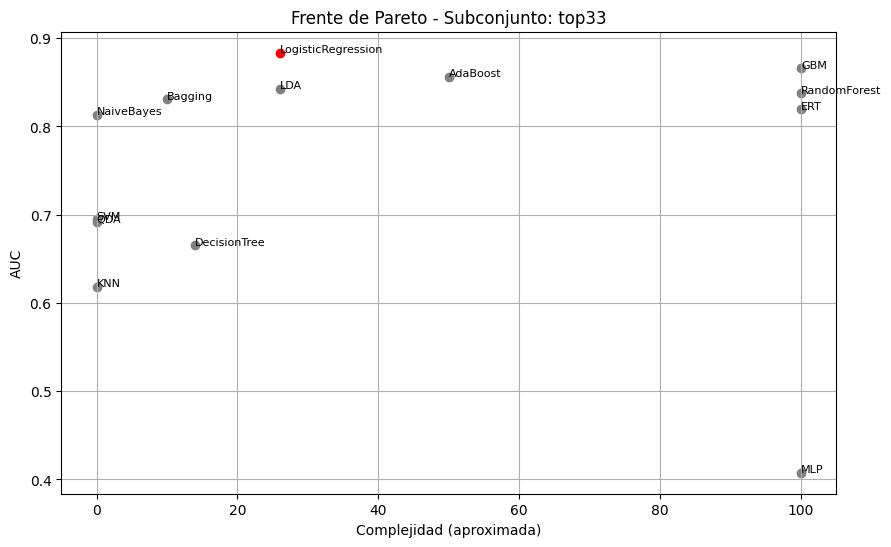

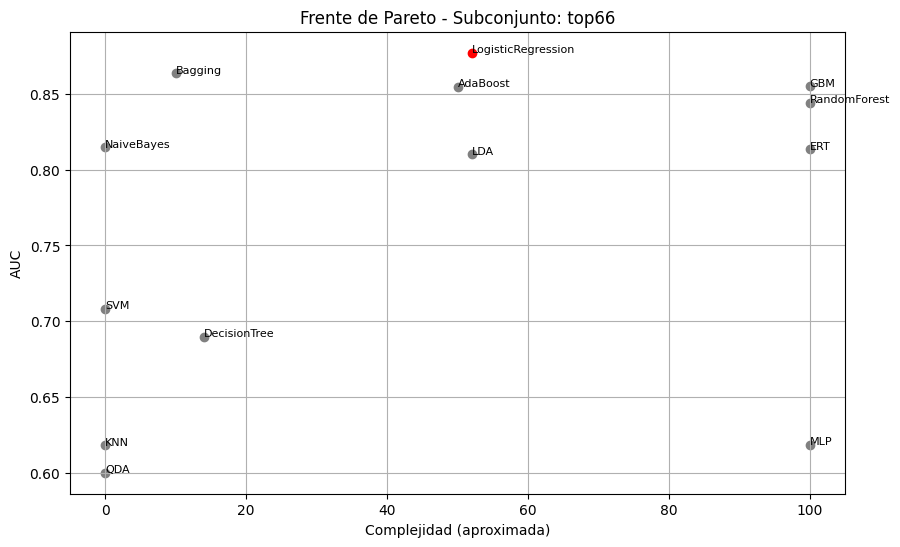

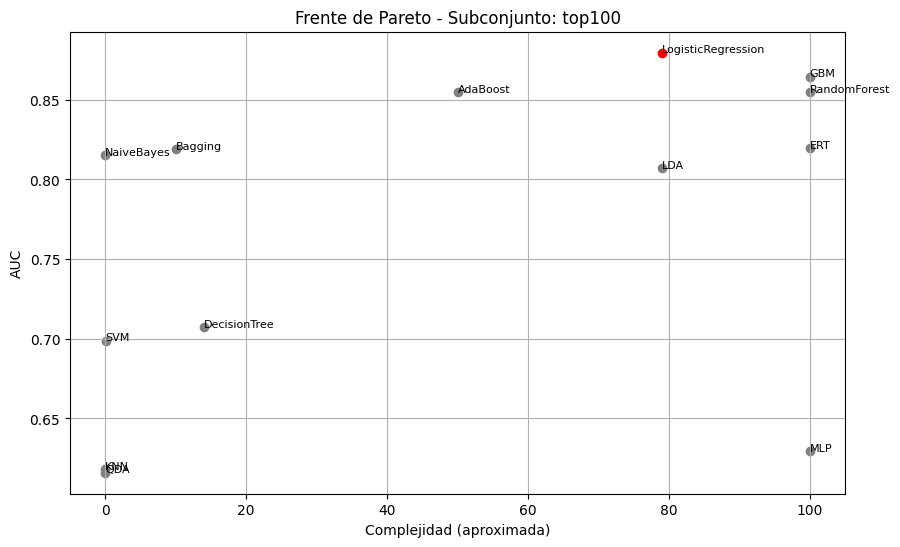

In [ ]:
for subset_name in rashomon_df['Subset'].unique():
    subset_data = rashomon_df[rashomon_df['Subset'] == subset_name]

    plt.figure(figsize=(10, 6))
    for _, row in subset_data.iterrows():
        color = 'red' if row['WithinEpsilon'] else 'gray'
        plt.scatter(row['Complexity'], row['AUC'], label=row['Model'], color=color)zxes3{-  5}
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f"Frente de Pareto - Subconjunto: {subset_name}")
    plt.xlabel("Complejidad (aproximada)")
    plt.ylabel("AUC")
    plt.grid(True)
    plt.show()

In [42]:
# Definir subconjuntos basados en porcentajes del ranking de atributos
total_features = ranking_df.shape[0]
top_33_count = max(1, int(total_features * 0.33))
top_66_count = max(1, int(total_features * 0.66))

feature_sets = {
    'top33': ranking_df.sort_values("Rank").head(top_33_count).index.tolist(),
    'top66': ranking_df.sort_values("Rank").head(top_66_count).index.tolist(),
    'top100': ranking_df.sort_values("Rank").index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC

for subset_name, features in feature_sets.items():
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_sub, y, test_size=0.25, random_state=42)

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)
            try:
                y_prob = model.predict_proba(X_valid_r)[:, 1]
            except:
                y_prob = y_pred

            auc = roc_auc_score(y_valid_r, y_prob)
            best_auc = max(best_auc, auc)

            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            else:
                complexity = train_time

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'Error with {model_label} on {subset_name}:', e)

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

rashomon_df = pd.DataFrame(rashomon_results)


In [43]:
# Crear resumen por subconjunto
summary = rashomon_df.groupby('Subset').agg({
    'RashomonVolume': 'first',
    'AUC': ['mean', 'max'],
    'Complexity': 'mean'
}).reset_index()

summary.columns = ['Subset', 'RashomonVolume', 'AUC_Mean', 'AUC_Max', 'Complexity_Mean']
summary = summary.sort_values("Subset")

# Mostrar con formato
display(summary.style.format({
    "AUC_Mean": "{:.3f}",
    "AUC_Max": "{:.3f}",
    "Complexity_Mean": "{:.1f}"
}))

,Subset,RashomonVolume,AUC_Mean,AUC_Max,Complexity_Mean
0,top100,1,0.776,0.880,48.6
1,top33,2,0.780,0.884,40.5
2,top66,2,0.777,0.877,44.5


In [44]:
# Exportar resumen a CSV
summary.to_csv("rashomon_summary.csv", index=False)
print("Resumen exportado como 'rashomon_summary_HeartDisease.csv'")

Resumen exportado como 'rashomon_summary_HeartDisease.csv'


In [45]:
# Exportar todos los resultados individuales a CSV
rashomon_df.to_csv("rashomon_model_results_heartDisease.csv", index=False)
print("Resultados detallados exportados como 'rashomon_model_results_HeartDisease.csv'")

Resultados detallados exportados como 'rashomon_model_results_HeartDisease.csv'


In [46]:
# Identificar modelos en el frente de Pareto (AUC vs. Complejidad)
def is_pareto_efficient(df, perf_col="AUC", cost_col="Complexity"):
    is_efficient = []
    for i, row_i in df.iterrows():
        dominated = False
        for j, row_j in df.iterrows():
            if (
                (row_j[perf_col] >= row_i[perf_col])
                and (row_j[cost_col] <= row_i[cost_col])
                and ((row_j[perf_col] > row_i[perf_col]) or (row_j[cost_col] < row_i[cost_col]))
            ):
                dominated = True
                break
        is_efficient.append(not dominated)
    return is_efficient

# Aplicar por subconjunto
pareto_df_list = []
for subset in rashomon_df['Subset'].unique():
    df_subset = rashomon_df[rashomon_df['Subset'] == subset].copy()
    df_subset['ParetoFront'] = is_pareto_efficient(df_subset)
    pareto_df_list.append(df_subset)

pareto_df = pd.concat(pareto_df_list)

# Exportar modelos en el frente de Pareto
pareto_df[pareto_df['ParetoFront']].to_csv("rashomon_pareto_models.csv", index=False)
print("Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'")

Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'


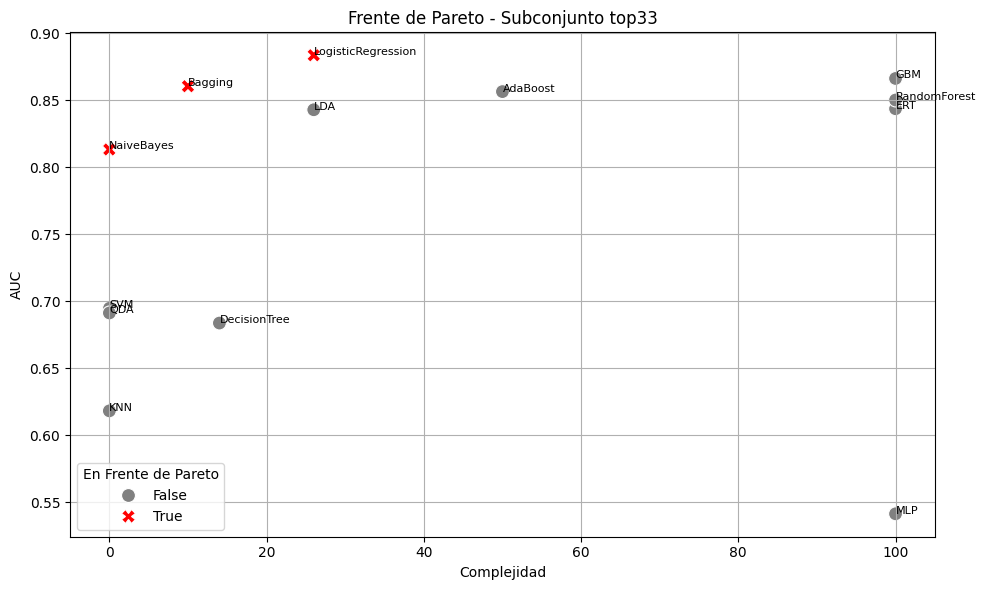

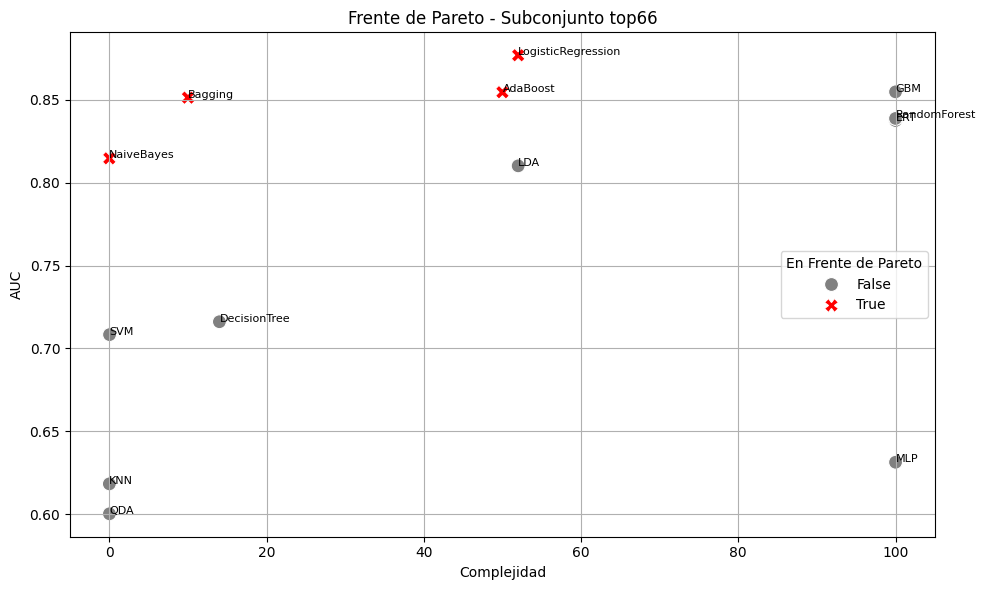

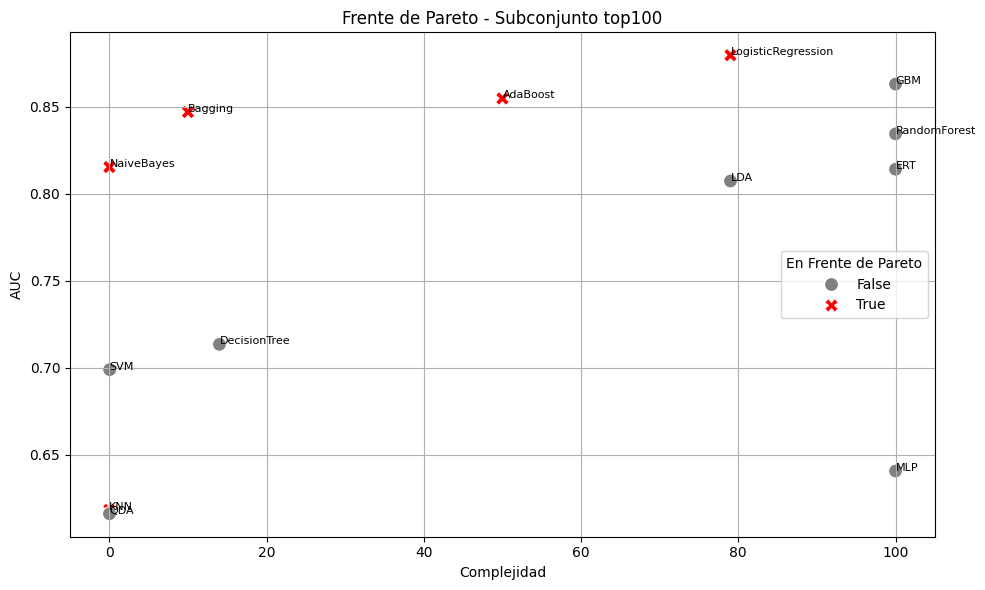

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización del frente de Pareto para cada subconjunto
for subset in pareto_df['Subset'].unique():
    data = pareto_df[pareto_df['Subset'] == subset]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Complexity', y='AUC',
        hue='ParetoFront',
        style='ParetoFront',
        palette={True: 'red', False: 'gray'},
        data=data,
        s=100
    )
    for _, row in data.iterrows():
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f'Frente de Pareto - Subconjunto {subset}')
    plt.xlabel('Complejidad')
    plt.ylabel('AUC')
    plt.legend(title='En Frente de Pareto')
    plt.grid(True)
    plt.tight_layout()
    plt.show()